# Analisi e Previsione della Produzione di Olio d'Oliva

Questo notebook esplora la relazione tra i dati meteorologici e la produzione annuale di olio d'oliva, con l'obiettivo di creare un modello predittivo.

In [1]:
!pip uninstall tensorflow tensorflow-macos tensorflow-metal keras -y

!pip install tensorflow


import tensorflow as tf
print(f"Keras version: {tf.keras.__version__}")
print(f"TensorFlow version: {tf.__version__}")

# GPU configuration
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

Found existing installation: tensorflow 2.16.2
Uninstalling tensorflow-2.16.2:
  Successfully uninstalled tensorflow-2.16.2
Found existing installation: keras 3.6.0
Uninstalling keras-3.6.0:
  Successfully uninstalled keras-3.6.0
  Using cached tensorflow-2.16.2-cp39-cp39-macosx_10_15_x86_64.whl.metadata (4.1 kB)
  Using cached keras-3.6.0-py3-none-any.whl.metadata (5.8 kB)
Using cached tensorflow-2.16.2-cp39-cp39-macosx_10_15_x86_64.whl (259.5 MB)
Using cached keras-3.6.0-py3-none-any.whl (1.2 MB)


2024-10-25 23:04:43.339945: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Keras version: 3.6.0
TensorFlow version: 2.16.2


In [2]:
# Test semplice per verificare che la GPU funzioni
def test_gpu():
    print("TensorFlow version:", tf.__version__)
    print("\nDispositivi disponibili:")
    print(tf.config.list_physical_devices())

    # Creiamo e moltiplichiamo due tensori sulla GPU
    with tf.device('/GPU:0'):
        a = tf.random.normal([10000, 10000])
        b = tf.random.normal([10000, 10000])
        c = tf.matmul(a, b)

    print("\nShape del risultato:", c.shape)
    print("Device del tensore:", c.device)
    return "Test completato con successo!"

test_gpu()

TensorFlow version: 2.16.2

Dispositivi disponibili:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

Shape del risultato: (10000, 10000)
Device del tensore: /job:localhost/replica:0/task:0/device:CPU:0


'Test completato con successo!'

In [3]:
!pip install numpy
!pip install pandas

!pip install keras
!pip install scikit-learn
!pip install matplotlib
!pip install joblib
!pip install pyarrow
!pip install fastparquet
!pip install scipy
!pip install seaborn
!pip install pysolar

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from tensorflow.keras.layers import Input, Dense, Dropout, Bidirectional, LSTM, LayerNormalization, Add, GlobalAveragePooling1D, Activation, BatchNormalization, MultiHeadAttention, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from datetime import datetime
import os
import json
import joblib
import re
import pyarrow as pa
import pyarrow.parquet as pq

random_state_value = 42

## 1. Caricamento e preparazione dei Dati Meteo

In [5]:
# Function to convert csv to parquet
def csv_to_parquet(csv_file, parquet_file, chunksize=100000):
    writer = None

    for chunk in pd.read_csv(csv_file, chunksize=chunksize):
        if writer is None:

            table = pa.Table.from_pandas(chunk)
            writer = pq.ParquetWriter(parquet_file, table.schema)
        else:
            table = pa.Table.from_pandas(chunk)

        writer.write_table(table)

    if writer:
        writer.close()

    print(f"File conversion completed : {csv_file} -> {parquet_file}")


def read_json_files(folder_path):
    all_data = []

    file_list = sorted(os.listdir(folder_path))

    for filename in file_list:
        if filename.endswith('.json'):
            file_path = os.path.join(folder_path, filename)
            try:
                with open(file_path, 'r') as file:
                    data = json.load(file)
                    all_data.extend(data['days'])
            except Exception as e:
                print(f"Error processing file '{filename}': {str(e)}")

    return all_data


def create_weather_dataset(data):
    dataset = []
    seen_datetimes = set()

    for day in data:
        date = day['datetime']
        for hour in day['hours']:
            datetime_str = f"{date} {hour['datetime']}"

            # Verifico se questo datetime è già stato visto
            if datetime_str in seen_datetimes:
                continue

            seen_datetimes.add(datetime_str)

            if isinstance(hour['preciptype'], list):
                preciptype = "__".join(hour['preciptype'])
            else:
                preciptype = hour['preciptype'] if hour['preciptype'] else ""

            conditions = hour['conditions'].replace(', ', '__').replace(' ', '_').lower()

            row = {
                'datetime': datetime_str,
                'temp': hour['temp'],
                'feelslike': hour['feelslike'],
                'humidity': hour['humidity'],
                'dew': hour['dew'],
                'precip': hour['precip'],
                'snow': hour['snow'],
                'preciptype': preciptype.lower(),
                'windspeed': hour['windspeed'],
                'winddir': hour['winddir'],
                'pressure': hour['pressure'],
                'cloudcover': hour['cloudcover'],
                'visibility': hour['visibility'],
                'solarradiation': hour['solarradiation'],
                'solarenergy': hour['solarenergy'],
                'uvindex': hour['uvindex'],
                'conditions': conditions,
                'tempmax': day['tempmax'],
                'tempmin': day['tempmin'],
                'precipprob': day['precipprob'],
                'precipcover': day['precipcover']
            }
            dataset.append(row)

    dataset.sort(key=lambda x: datetime.strptime(x['datetime'], "%Y-%m-%d %H:%M:%S"))

    return pd.DataFrame(dataset)


folder_path = './data/weather'
raw_data = read_json_files(folder_path)
weather_data = create_weather_dataset(raw_data)
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'], errors='coerce')
weather_data['date'] = weather_data['datetime'].dt.date
weather_data = weather_data.dropna(subset=['datetime'])
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'])
weather_data['year'] = weather_data['datetime'].dt.year
weather_data['month'] = weather_data['datetime'].dt.month
weather_data['day'] = weather_data['datetime'].dt.day
weather_data.head()

weather_data.to_parquet('./data/weather_data.parquet')

In [10]:
# Crea le sequenze per LSTM
def create_sequences(timesteps, X, y=None):
    """
    Crea sequenze temporali dai dati.
    
    Parameters:
    -----------
    X : array-like
        Dati di input
    timesteps : int
        Numero di timestep per ogni sequenza
    y : array-like, optional
        Target values. Se None, crea sequenze solo per X
        
    Returns:
    --------
    tuple o array
        Se y è fornito: (X_sequences, y_sequences)
        Se y è None: X_sequences
    """
    Xs = []
    for i in range(len(X) - timesteps):
        Xs.append(X[i:i + timesteps])

    if y is not None:
        ys = []
        for i in range(len(X) - timesteps):
            ys.append(y[i + timesteps])
        return np.array(Xs), np.array(ys)

    return np.array(Xs)


# Funzioni per costruire il modello LSTM avanzato
def create_residual_lstm_layer(x, units, dropout_rate, l2_reg=0.01):
    residual = x
    x = Bidirectional(LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_reg)))(x)
    x = LayerNormalization()(x)
    x = Dropout(dropout_rate)(x)
    # Adjust residual dimension
    if int(residual.shape[-1]) != 2 * units:
        residual = Dense(2 * units, activation='linear')(residual)
    x = Add()([x, residual])
    return x


def attention_block(x, units, num_heads=8):
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=units)(x, x)
    x = Add()([x, attention])
    x = LayerNormalization()(x)
    return x


def build_advanced_model(input_shape, l2_lambda=0.005):
    inputs = Input(shape=input_shape)
    x = create_residual_lstm_layer(inputs, 64, 0.2, l2_lambda)
    x = create_residual_lstm_layer(x, 32, 0.2, l2_lambda)
    x = create_residual_lstm_layer(x, 16, 0.1, l2_lambda)
    x = attention_block(x, 16, num_heads=8)
    x = MaxPooling1D()(x)
    x = Dense(32, kernel_regularizer=l2(l2_lambda))(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    x = Dropout(0.1)(x)
    x = Dense(16, kernel_regularizer=l2(l2_lambda))(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    x = Dropout(0.1)(x)
    outputs = Dense(1, kernel_regularizer=l2(l2_lambda))(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model


def get_season(date):
    month = date.month
    day = date.day
    if (month == 12 and day >= 21) or (month <= 3 and day < 20):
        return 'Winter'
    elif (month == 3 and day >= 20) or (month <= 6 and day < 21):
        return 'Spring'
    elif (month == 6 and day >= 21) or (month <= 9 and day < 23):
        return 'Summer'
    elif (month == 9 and day >= 23) or (month <= 12 and day < 21):
        return 'Autumn'
    else:
        return 'Unknown'


def get_time_period(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'


def add_time_features(df):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['timestamp'] = df['datetime'].astype(np.int64) // 10 ** 9
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['minute'] = df['datetime'].dt.minute
    df['hour_sin'] = np.sin(df['hour'] * (2 * np.pi / 24))
    df['hour_cos'] = np.cos(df['hour'] * (2 * np.pi / 24))
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['day_of_year'] = df['datetime'].dt.dayofyear
    df['week_of_year'] = df['datetime'].dt.isocalendar().week.astype(int)
    df['quarter'] = df['datetime'].dt.quarter
    df['is_month_end'] = df['datetime'].dt.is_month_end.astype(int)
    df['is_quarter_end'] = df['datetime'].dt.is_quarter_end.astype(int)
    df['is_year_end'] = df['datetime'].dt.is_year_end.astype(int)
    df['month_sin'] = np.sin(df['month'] * (2 * np.pi / 12))
    df['month_cos'] = np.cos(df['month'] * (2 * np.pi / 12))
    df['day_of_year_sin'] = np.sin(df['day_of_year'] * (2 * np.pi / 365.25))
    df['day_of_year_cos'] = np.cos(df['day_of_year'] * (2 * np.pi / 365.25))
    df['season'] = df['datetime'].apply(get_season)
    df['time_period'] = df['hour'].apply(get_time_period)
    return df


# Carica il dataset
weather_data = pd.read_parquet('./data/weather_data.parquet')

# Aggiungi le caratteristiche temporali
weather_data = add_time_features(weather_data)

# Encoding delle variabili categoriali
weather_data = pd.get_dummies(weather_data, columns=['season', 'time_period'], drop_first=True)

weather_data.to_parquet('./data/weather_data_extended.parquet')

# Dividi i dati in quelli dopo il 2010 e quelli prima del 2010
data_after_2010 = weather_data[weather_data['year'] >= 2010].copy()
data_before_2010 = weather_data[weather_data['year'] < 2010].copy()

# Aggiorna le target variables se necessario
target_variables = ['solarradiation', 'solarenergy', 'uvindex']

# Seleziona le features
features = [
               'temp', 'tempmin', 'tempmax', 'humidity', 'cloudcover', 'windspeed', 'pressure', 'visibility',
               'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'day_of_year_sin', 'day_of_year_cos',
           ] + [col for col in weather_data.columns if 'season_' in col or 'time_period_' in col]

# Prepara data_after_2010
data_after_2010 = data_after_2010.sort_values('datetime')
data_after_2010.set_index('datetime', inplace=True)

# Interpola eventuali valori mancanti nelle variabili target
columns_to_interpolate = target_variables
for column in columns_to_interpolate:
    data_after_2010[column] = data_after_2010[column].interpolate(method='time')

# Rimuovi eventuali valori mancanti residui
data_after_2010.dropna(subset=features + target_variables, inplace=True)

# Crea X e y
X = data_after_2010[features].values
y = data_after_2010[target_variables].values

# Normalizza le features
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)


def prepare_multi_target_datasets(X_scaled, y, target_variables):
    """
    Prepara dataset separati per ogni target variable e restituisce anche gli scaler
    per un uso successivo in fase di predizione.
    
    Parameters:
    -----------
    X_scaled : numpy.ndarray
        Features già scalate
    y : numpy.ndarray
        Target variables (matrice con una colonna per ogni target)
    target_variables : list
        Lista dei nomi delle variabili target
    
    Returns:
    --------
    tuple (dict, dict)
        - Primo dict: contiene i dataset per ogni target
        - Secondo dict: contiene gli scaler per ogni target
    """

    # Inizializza i dizionari per contenere i dataset e gli scaler
    train_datasets = {}
    scalers_dict = {}

    # Scala e splitta i dati per ogni target
    for i, target in enumerate(target_variables):
        # Scala il target corrente
        scaler = MinMaxScaler()
        y_scaled_current = scaler.fit_transform(y[:, i].reshape(-1, 1)).flatten()
        scalers_dict[target] = scaler

        # Split dei dati per il target corrente
        X_train_full, X_test, y_train_full, y_test = train_test_split(
            X_scaled,
            y_scaled_current,
            test_size=0.2,
            shuffle=False
        )

        # Ulteriore split per validation
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_full,
            y_train_full,
            test_size=0.2,
            shuffle=False
        )

        # Salva i dataset per questo target
        train_datasets[target] = {
            'X_train': X_train,
            'X_val': X_val,
            'X_test': X_test,
            'y_train': y_train.reshape(-1, 1),
            'y_val': y_val.reshape(-1, 1),
            'y_test': y_test.reshape(-1, 1)
        }

    return train_datasets, scalers_dict


datasets, scalers = prepare_multi_target_datasets(X_scaled, y, target_variables)

In [11]:
# numero di timesteps (utilizziamo le ultime 24 ore)
timesteps = 24

# Costruisci il modello per ogni variabile target
models = {}
histories = {}
for i, target in enumerate(target_variables):
    target_data = datasets[target]
    target_scaler = scalers[target]

    X_train = target_data['X_train']
    y_train = target_data['y_train']
    X_val = target_data['X_val']
    y_val = target_data['y_val']
    X_test = target_data['X_test']
    y_test = target_data['y_test']

    num_features = X_train.shape[1]

    X_train_seq, y_train_seq = create_sequences(timesteps, X_train, y_train)
    X_val_seq, y_val_seq = create_sequences(timesteps, X_val, y_val)
    X_test_seq, y_test_seq = create_sequences(timesteps, X_test, y_test)

    print(X_train_seq.shape, y_train_seq.shape)
    print(X_val_seq.shape, y_val_seq.shape)
    print(X_test_seq.shape, y_test_seq.shape)
    
    print(f"Addestramento del modello per: {target}")
    model = build_advanced_model((timesteps, num_features), l2_lambda=0.001)
    optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    )
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=50,
        batch_size=180,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    test_loss = model.evaluate(X_test_seq, y_test_seq)
    print(f'Test MAE per {target}: {test_loss:.4f}')
    models[target] = model
    histories[target] = history


(82972, 24, 21) (82972, 1)
(20725, 24, 21) (20725, 1)
(25913, 24, 21) (25913, 1)
Addestramento del modello per: solarradiation
Epoch 1/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 145s 293ms/step - loss: 0.3459 - val_loss: 0.0512 - learning_rate: 0.0010
Epoch 2/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 122s 266ms/step - loss: 0.0346 - val_loss: 0.0247 - learning_rate: 0.0010
Epoch 3/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 132s 287ms/step - loss: 0.0148 - val_loss: 0.0280 - learning_rate: 0.0010
Epoch 4/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 121s 262ms/step - loss: 0.0102 - val_loss: 0.0496 - learning_rate: 0.0010
Epoch 5/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 125s 271ms/step - loss: 0.0130 - val_loss: 0.0097 - learning_rate: 0.0010
Epoch 6/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 128s 277ms/step - loss: 0.0078 - val_loss: 0.0151 - learning_rate: 0.0010
Epoch 7/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 133s 288ms/step - loss: 0.0073 - val_loss: 0.0104 - learning_rate: 0.0010
Epoch 8/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 140s 305ms/step - loss: 0.0072 - va

KeyboardInterrupt: 

In [ ]:
import joblib
import os


def save_models_and_scalers(models, scaler_X, scalers_y, target_variables, base_path='models'):
    """
    Salva i modelli e gli scaler nella cartella models.
    
    Parameters:
    -----------
    models : dict
        Dizionario contenente i modelli per ogni variabile target
    scaler_X : MinMaxScaler
        Scaler unico per tutte le feature di input
    scalers_y : dict
        Dizionario contenente gli scaler per le variabili target
    target_variables : list
        Lista delle variabili target
    base_path : str
        Percorso base dove salvare i modelli (default: 'models')
    """

    # Crea la cartella se non esiste
    os.makedirs(base_path, exist_ok=True)

    # Salva lo scaler X generale
    scaler_x_path = os.path.join(base_path, 'scaler_x.joblib')
    joblib.dump(scaler_X, scaler_x_path)

    # Salva i modelli e gli scaler Y per ogni variabile target
    for target in target_variables:
        # Crea una sottocartella per ogni target
        target_path = os.path.join(base_path, target)
        os.makedirs(target_path, exist_ok=True)

        # Salva il modello
        model_path = os.path.join(target_path, 'model.joblib')
        joblib.dump(models[target], model_path)

        # Salva lo scaler Y
        scaler_y_path = os.path.join(target_path, 'scaler_y.joblib')
        joblib.dump(scalers_y[target], scaler_y_path)

    # Salva la lista delle variabili target
    target_vars_path = os.path.join(base_path, 'target_variables.joblib')
    joblib.dump(target_variables, target_vars_path)

    print(f"Modelli e scaler salvati in: {base_path}")


def load_models_and_scalers(base_path='models'):
    """
    Carica i modelli e gli scaler dalla cartella models.
    
    Parameters:
    -----------
    base_path : str
        Percorso della cartella contenente i modelli salvati (default: 'models')
    
    Returns:
    --------
    tuple
        (models, scaler_X, scalers_y, target_variables)
    """

    # Carica la lista delle variabili target
    target_vars_path = os.path.join(base_path, 'target_variables.joblib')
    target_variables = joblib.load(target_vars_path)

    # Carica lo scaler X generale
    scaler_x_path = os.path.join(base_path, 'scaler_x.joblib')
    scaler_X = joblib.load(scaler_x_path)

    # Inizializza i dizionari
    models = {}
    scalers_y = {}

    # Carica i modelli e gli scaler per ogni variabile target
    for target in target_variables:
        target_path = os.path.join(base_path, target)

        # Carica il modello
        model_path = os.path.join(target_path, 'model.joblib')
        models[target] = joblib.load(model_path)

        # Carica lo scaler Y
        scaler_y_path = os.path.join(target_path, 'scaler_y.joblib')
        scalers_y[target] = joblib.load(scaler_y_path)

    print(f"Modelli e scaler caricati da: {base_path}")
    return models, scaler_X, scalers_y, target_variables


save_models_and_scalers(models, scaler_X, scalers, target_variables)

In [64]:
# Previsione delle variabili mancanti per data_before_2010
# Prepara data_before_2010
data_before_2010 = data_before_2010.sort_values('datetime')
data_before_2010.set_index('datetime', inplace=True)

# Assicurati che le features non abbiano valori mancanti
data_before_2010[features] = data_before_2010[features].ffill()
data_before_2010[features] = data_before_2010[features].bfill()

Addestramento del modello per: solarradiation
Epoch 1/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 128s 256ms/step - loss: 0.5408 - val_loss: 0.1378 - learning_rate: 0.0010
Epoch 2/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 95s 207ms/step - loss: 0.1200 - val_loss: 0.0832 - learning_rate: 0.0010
Epoch 3/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 93s 202ms/step - loss: 0.0805 - val_loss: 0.0689 - learning_rate: 0.0010
Epoch 4/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 85s 184ms/step - loss: 0.0687 - val_loss: 0.0826 - learning_rate: 0.0010
Epoch 5/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 96s 209ms/step - loss: 0.0646 - val_loss: 0.0619 - learning_rate: 0.0010
Epoch 6/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 94s 203ms/step - loss: 0.0616 - val_loss: 0.0616 - learning_rate: 0.0010
Epoch 7/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 96s 207ms/step - loss: 0.0606 - val_loss: 0.0588 - learning_rate: 0.0010
Epoch 8/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 93s 202ms/step - loss: 0.0600 - val_loss: 0.0580 - learning_rate: 0.0010
Epoch 9/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 96s 208ms

ValueError: Found array with dim 3. None expected <= 2.

In [65]:
# Crea X per data_before_2010
X_before = data_before_2010[features].values
X_before_scaled = scaler_X.transform(X_before)

# Crea le sequenze per LSTM
X_before_seq = create_sequences(timesteps, X_before_scaled)

# Prevedi le variabili mancanti
for i, target in enumerate(target_variables):
    print(f"Previsione di {target} per data_before_2010")
    y_pred_scaled = models[target].predict(X_before_seq)
    # Ricostruisci i valori originali
    scaler = scalers_y[target]
    y_pred = scaler.inverse_transform(y_pred_scaled)

    # Allinea le previsioni con le date corrette
    dates = data_before_2010.index[timesteps:]
    data_before_2010.loc[dates, target] = y_pred

# Gestisci eventuali valori iniziali mancanti
data_before_2010[target_variables] = data_before_2010[target_variables].bfill()

# Combina data_before_2010 e data_after_2010
weather_data_complete = pd.concat([data_before_2010, data_after_2010], axis=0)
weather_data_complete = weather_data_complete.sort_index()

# Salva il dataset completo
weather_data_complete.reset_index(inplace=True)
weather_data_complete.to_parquet('./data/weather_data_complete.parquet', index=False)


Previsione di solarradiation per data_before_2010
7122/7122 ━━━━━━━━━━━━━━━━━━━━ 172s 24ms/step


ValueError: Found array with dim 3. None expected <= 2.

## 2. Esplorazione dei Dati Meteo

In [21]:
weather_data = pd.read_parquet('./data/weather_data_complete.parquet')

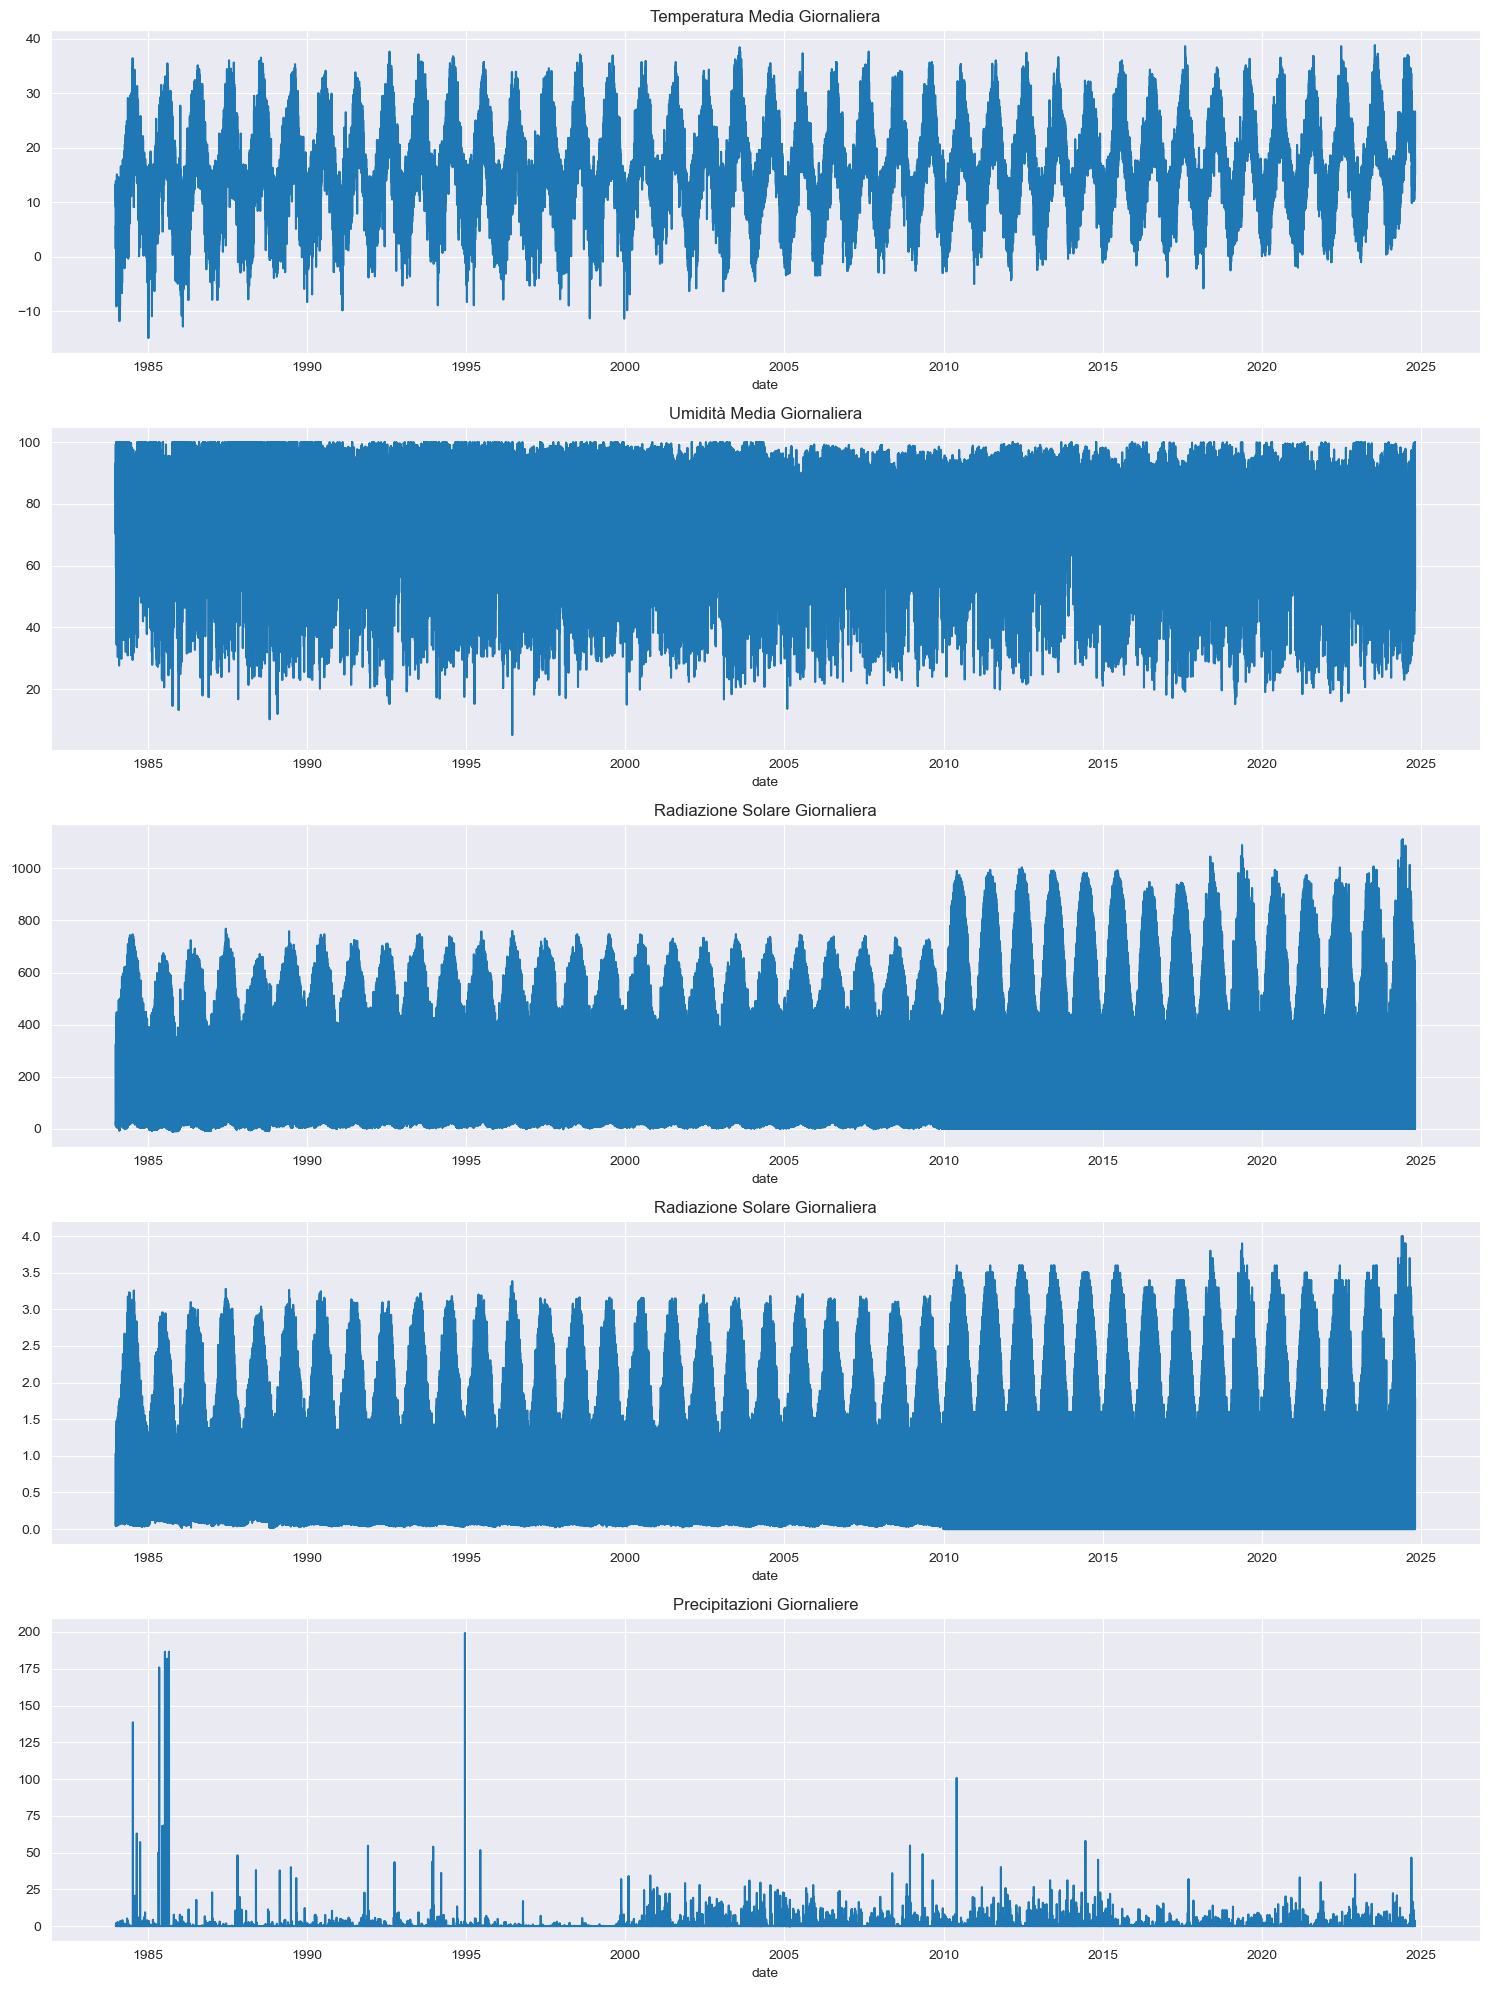

In [22]:
# Visualizzazione delle tendenze temporali
fig, axes = plt.subplots(5, 1, figsize=(15, 20))
weather_data.set_index('date')['temp'].plot(ax=axes[0], title='Temperatura Media Giornaliera')
weather_data.set_index('date')['humidity'].plot(ax=axes[1], title='Umidità Media Giornaliera')
weather_data.set_index('date')['solarradiation'].plot(ax=axes[2], title='Radiazione Solare Giornaliera')
weather_data.set_index('date')['solarenergy'].plot(ax=axes[3], title='Radiazione Solare Giornaliera')
weather_data.set_index('date')['precip'].plot(ax=axes[4], title='Precipitazioni Giornaliere')
plt.tight_layout()
plt.show()

## 3. Simulazione dei Dati di Produzione Annuale

In [23]:

# Esempio di utilizzo
olive_varieties = pd.read_csv('./data/variety_olive_oil_production.csv')


def add_olive_water_consumption_correlation(dataset):
    # Dati simulati per il fabbisogno d'acqua e la correlazione con la temperatura
    fabbisogno_acqua = {
        "Nocellara dell'Etna": {"Primavera": 1200, "Estate": 2000, "Autunno": 1000, "Inverno": 500, "Temperatura Ottimale": 18, "Resistenza": "Media"},
        "Leccino": {"Primavera": 1000, "Estate": 1800, "Autunno": 800, "Inverno": 400, "Temperatura Ottimale": 20, "Resistenza": "Alta"},
        "Frantoio": {"Primavera": 1100, "Estate": 1900, "Autunno": 900, "Inverno": 450, "Temperatura Ottimale": 19, "Resistenza": "Alta"},
        "Coratina": {"Primavera": 1300, "Estate": 2200, "Autunno": 1100, "Inverno": 550, "Temperatura Ottimale": 17, "Resistenza": "Media"},
        "Moraiolo": {"Primavera": 1150, "Estate": 2100, "Autunno": 900, "Inverno": 480, "Temperatura Ottimale": 18, "Resistenza": "Media"},
        "Pendolino": {"Primavera": 1050, "Estate": 1850, "Autunno": 850, "Inverno": 430, "Temperatura Ottimale": 20, "Resistenza": "Alta"},
        "Taggiasca": {"Primavera": 1000, "Estate": 1750, "Autunno": 800, "Inverno": 400, "Temperatura Ottimale": 19, "Resistenza": "Alta"},
        "Canino": {"Primavera": 1100, "Estate": 1900, "Autunno": 900, "Inverno": 450, "Temperatura Ottimale": 18, "Resistenza": "Media"},
        "Itrana": {"Primavera": 1200, "Estate": 2000, "Autunno": 1000, "Inverno": 500, "Temperatura Ottimale": 17, "Resistenza": "Media"},
        "Ogliarola": {"Primavera": 1150, "Estate": 1950, "Autunno": 900, "Inverno": 480, "Temperatura Ottimale": 18, "Resistenza": "Media"},
        "Biancolilla": {"Primavera": 1050, "Estate": 1800, "Autunno": 850, "Inverno": 430, "Temperatura Ottimale": 19, "Resistenza": "Alta"}
    }

    # Calcola il fabbisogno idrico annuale per ogni varietà
    for varieta in fabbisogno_acqua:
        fabbisogno_acqua[varieta]["Annuale"] = sum([fabbisogno_acqua[varieta][stagione] for stagione in ["Primavera", "Estate", "Autunno", "Inverno"]])

    # Aggiungiamo le nuove colonne al dataset
    dataset["Fabbisogno Acqua Primavera (m³/ettaro)"] = dataset["Varietà di Olive"].apply(lambda x: fabbisogno_acqua[x]["Primavera"])
    dataset["Fabbisogno Acqua Estate (m³/ettaro)"] = dataset["Varietà di Olive"].apply(lambda x: fabbisogno_acqua[x]["Estate"])
    dataset["Fabbisogno Acqua Autunno (m³/ettaro)"] = dataset["Varietà di Olive"].apply(lambda x: fabbisogno_acqua[x]["Autunno"])
    dataset["Fabbisogno Acqua Inverno (m³/ettaro)"] = dataset["Varietà di Olive"].apply(lambda x: fabbisogno_acqua[x]["Inverno"])
    dataset["Fabbisogno Idrico Annuale (m³/ettaro)"] = dataset["Varietà di Olive"].apply(lambda x: fabbisogno_acqua[x]["Annuale"])
    dataset["Temperatura Ottimale"] = dataset["Varietà di Olive"].apply(lambda x: fabbisogno_acqua[x]["Temperatura Ottimale"])
    dataset["Resistenza alla Siccità"] = dataset["Varietà di Olive"].apply(lambda x: fabbisogno_acqua[x]["Resistenza"])

    return dataset


olive_varieties = add_olive_water_consumption_correlation(olive_varieties)

olive_varieties.to_parquet("./data/olive_varieties.parquet")

In [55]:
def preprocess_weather_data(weather_df):
    # Calcola statistiche mensili per ogni anno
    monthly_weather = weather_df.groupby(['year', 'month']).agg({
        'temp': ['mean', 'min', 'max'],
        'humidity': 'mean',
        'precip': 'sum',
        'windspeed': 'mean',
        'cloudcover': 'mean',
        'solarradiation': 'sum',
        'solarenergy': 'sum',
        'uvindex': 'max'
    }).reset_index()

    monthly_weather.columns = ['year', 'month'] + [f'{col[0]}_{col[1]}' for col in monthly_weather.columns[2:]]
    return monthly_weather


def get_growth_phase(month):
    if month in [12, 1, 2]:
        return 'dormancy'
    elif month in [3, 4, 5]:
        return 'flowering'
    elif month in [6, 7, 8]:
        return 'fruit_set'
    else:
        return 'ripening'


def calculate_weather_effect(row, optimal_temp):
    # Effetti base
    temp_effect = -0.1 * (row['temp_mean'] - optimal_temp) ** 2
    rain_effect = -0.05 * (row['precip_sum'] - 600) ** 2 / 10000
    sun_effect = 0.1 * row['solarenergy_sum'] / 1000

    # Fattori di scala basati sulla fase di crescita
    if row['growth_phase'] == 'dormancy':
        temp_scale = 0.5
        rain_scale = 0.2
        sun_scale = 0.1
    elif row['growth_phase'] == 'flowering':
        temp_scale = 2.0
        rain_scale = 1.5
        sun_scale = 1.0
    elif row['growth_phase'] == 'fruit_set':
        temp_scale = 1.5
        rain_scale = 1.0
        sun_scale = 0.8
    else:  # ripening
        temp_scale = 1.0
        rain_scale = 0.5
        sun_scale = 1.2

    # Calcolo dell'effetto combinato
    combined_effect = (
            temp_scale * temp_effect +
            rain_scale * rain_effect +
            sun_scale * sun_effect
    )

    # Aggiustamenti specifici per fase
    if row['growth_phase'] == 'flowering':
        combined_effect -= 0.5 * max(0, row['precip_sum'] - 50)  # Penalità per pioggia eccessiva durante la fioritura
    elif row['growth_phase'] == 'fruit_set':
        combined_effect += 0.3 * max(0, row['temp_mean'] - (optimal_temp + 5))  # Bonus per temperature più alte durante la formazione dei frutti

    return combined_effect


def calculate_water_need(weather_data, base_need, optimal_temp):
    # Calcola il fabbisogno idrico basato su temperatura e precipitazioni
    temp_factor = 1 + 0.05 * (weather_data['temp_mean'] - optimal_temp)  # Aumenta del 5% per ogni grado sopra l'ottimale
    rain_factor = 1 - 0.001 * weather_data['precip_sum']  # Diminuisce leggermente con l'aumentare delle precipitazioni
    return base_need * temp_factor * rain_factor


def clean_column_name(name):
    # Rimuove caratteri speciali e spazi, converte in snake_case e abbrevia
    name = re.sub(r'[^a-zA-Z0-9\s]', '', name)  # Rimuove caratteri speciali
    name = name.lower().replace(' ', '_')  # Converte in snake_case

    # Abbreviazioni comuni
    abbreviations = {
        'production': 'prod',
        'percentage': 'pct',
        'hectare': 'ha',
        'tonnes': 't',
        'litres': 'l',
        'minimum': 'min',
        'maximum': 'max',
        'average': 'avg'
    }

    for full, abbr in abbreviations.items():
        name = name.replace(full, abbr)

    return name


def create_technique_mapping(olive_varieties, mapping_path='models/technique_mapping.joblib'):
    # Estrai tutte le tecniche uniche dal dataset e convertile in lowercase
    all_techniques = olive_varieties['Tecnica di Coltivazione'].str.lower().unique()

    # Crea il mapping partendo da 1
    technique_mapping = {tech: i + 1 for i, tech in enumerate(sorted(all_techniques))}

    # Salva il mapping
    os.makedirs(os.path.dirname(mapping_path), exist_ok=True)
    joblib.dump(technique_mapping, mapping_path)

    return technique_mapping


def encode_techniques(df, mapping_path='models/technique_mapping.joblib'):
    if not os.path.exists(mapping_path):
        raise FileNotFoundError(f"Mapping not found at {mapping_path}. Run create_technique_mapping first.")

    technique_mapping = joblib.load(mapping_path)

    # Trova tutte le colonne delle tecniche
    tech_columns = [col for col in df.columns if col.endswith('_tech')]

    # Applica il mapping a tutte le colonne delle tecniche
    for col in tech_columns:
        df[col] = df[col].str.lower().map(technique_mapping).fillna(0).astype(int)

    return df


def decode_techniques(df, mapping_path='models/technique_mapping.joblib'):
    if not os.path.exists(mapping_path):
        raise FileNotFoundError(f"Mapping not found at {mapping_path}")

    technique_mapping = joblib.load(mapping_path)
    reverse_mapping = {v: k for k, v in technique_mapping.items()}
    reverse_mapping[0] = ''  # Aggiungi un mapping per 0 a stringa vuota

    # Trova tutte le colonne delle tecniche
    tech_columns = [col for col in df.columns if col.endswith('_tech')]

    # Applica il reverse mapping a tutte le colonne delle tecniche
    for col in tech_columns:
        df[col] = df[col].map(reverse_mapping)

    return df


def decode_single_technique(technique_value, mapping_path='models/technique_mapping.joblib'):
    if not os.path.exists(mapping_path):
        raise FileNotFoundError(f"Mapping not found at {mapping_path}")

    technique_mapping = joblib.load(mapping_path)
    reverse_mapping = {v: k for k, v in technique_mapping.items()}
    reverse_mapping[0] = ''

    return reverse_mapping.get(technique_value, '')


def simulate_olive_production(weather_data, olive_varieties, num_simulations=5, random_seed=None):
    """
    Simula la produzione di olive per diverse zone e varietà, considerando variazioni meteo specifiche per zona.
    
    Args:
        weather_data: DataFrame con dati meteorologici storici
        olive_varieties: DataFrame con informazioni sulle varietà di olive
        num_simulations: Numero di simulazioni/zone da generare
        random_seed: Seme per la riproducibilità dei risultati
    
    Returns:
        DataFrame con i risultati delle simulazioni per tutte le zone
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    create_technique_mapping(olive_varieties)
    monthly_weather = preprocess_weather_data(weather_data)
    all_results = []

    # Preparazione dati varietà
    all_varieties = olive_varieties['Varietà di Olive'].unique()
    variety_techniques = {
        variety: olive_varieties[olive_varieties['Varietà di Olive'] == variety]['Tecnica di Coltivazione'].unique()
        for variety in all_varieties
    }

    # Per ogni simulazione (anno)
    for sim in range(num_simulations):
        # Seleziona anno di base per questa simulazione
        selected_year = np.random.choice(monthly_weather['year'].unique())
        base_weather = monthly_weather[monthly_weather['year'] == selected_year].copy()
        base_weather.loc[:, 'growth_phase'] = base_weather['month'].apply(get_growth_phase)

        # Per ogni zona nella simulazione
        for zone in range(num_simulations):
            # Crea una copia dei dati meteo per questa zona specifica
            zone_weather = base_weather.copy()

            # Genera variazioni meteorologiche specifiche per questa zona
            zone_weather['temp_mean'] *= np.random.uniform(0.95, 1.05, len(zone_weather))
            zone_weather['precip_sum'] *= np.random.uniform(0.9, 1.1, len(zone_weather))
            zone_weather['solarenergy_sum'] *= np.random.uniform(0.95, 1.05, len(zone_weather))

            # Genera caratteristiche specifiche della zona
            num_varieties = np.random.randint(1, 4)  # 1-3 varietà per zona
            selected_varieties = np.random.choice(all_varieties, size=num_varieties, replace=False)
            hectares = np.random.uniform(1, 10)  # Dimensione del terreno
            percentages = np.random.dirichlet(np.ones(num_varieties))  # Distribuzione delle varietà

            # Inizializzazione contatori annuali
            annual_production = 0
            annual_min_oil = 0
            annual_max_oil = 0
            annual_avg_oil = 0
            annual_water_need = 0

            # Inizializzazione dizionario dati varietà
            variety_data = {clean_column_name(variety): {
                'tech': '',
                'pct': 0,
                'prod_t_ha': 0,
                'oil_prod_t_ha': 0,
                'oil_prod_l_ha': 0,
                'min_yield_pct': 0,
                'max_yield_pct': 0,
                'min_oil_prod_l_ha': 0,
                'max_oil_prod_l_ha': 0,
                'avg_oil_prod_l_ha': 0,
                'l_per_t': 0,
                'min_l_per_t': 0,
                'max_l_per_t': 0,
                'avg_l_per_t': 0,
                'olive_prod': 0,
                'min_oil_prod': 0,
                'max_oil_prod': 0,
                'avg_oil_prod': 0,
                'water_need': 0
            } for variety in all_varieties}

            # Simula produzione per ogni varietà selezionata
            for i, variety in enumerate(selected_varieties):
                # Seleziona tecnica di coltivazione casuale per questa varietà
                technique = np.random.choice(variety_techniques[variety])
                percentage = percentages[i]

                # Ottieni informazioni specifiche della varietà
                variety_info = olive_varieties[
                    (olive_varieties['Varietà di Olive'] == variety) &
                    (olive_varieties['Tecnica di Coltivazione'] == technique)
                    ].iloc[0]

                # Calcola produzione base con variabilità
                base_production = variety_info['Produzione (tonnellate/ettaro)'] * 1000 * percentage * hectares / 12
                base_production *= np.random.uniform(0.9, 1.1)  # Aggiungi variabilità alla produzione base

                # Calcola effetti meteo sulla produzione
                weather_effect = zone_weather.apply(
                    lambda row: calculate_weather_effect(row, variety_info['Temperatura Ottimale']),
                    axis=1
                )
                monthly_production = base_production * (1 + weather_effect / 10000)
                monthly_production *= np.random.uniform(0.95, 1.05, len(zone_weather))

                # Calcola produzione annuale per questa varietà
                annual_variety_production = monthly_production.sum()

                # Calcola rese di olio con variabilità
                min_yield_factor = np.random.uniform(0.95, 1.05)
                max_yield_factor = np.random.uniform(0.95, 1.05)
                avg_yield_factor = (min_yield_factor + max_yield_factor) / 2

                min_oil_production = annual_variety_production * variety_info['Min Litri per Tonnellata'] / 1000 * min_yield_factor
                max_oil_production = annual_variety_production * variety_info['Max Litri per Tonnellata'] / 1000 * max_yield_factor
                avg_oil_production = annual_variety_production * variety_info['Media Litri per Tonnellata'] / 1000 * avg_yield_factor

                # Calcola fabbisogno idrico
                base_water_need = (
                                          variety_info['Fabbisogno Acqua Primavera (m³/ettaro)'] +
                                          variety_info['Fabbisogno Acqua Estate (m³/ettaro)'] +
                                          variety_info['Fabbisogno Acqua Autunno (m³/ettaro)'] +
                                          variety_info['Fabbisogno Acqua Inverno (m³/ettaro)']
                                  ) / 4  # Media stagionale

                monthly_water_need = zone_weather.apply(
                    lambda row: calculate_water_need(row, base_water_need, variety_info['Temperatura Ottimale']),
                    axis=1
                )
                monthly_water_need *= np.random.uniform(0.95, 1.05, len(monthly_water_need))
                annual_variety_water_need = monthly_water_need.sum() * percentage * hectares

                # Aggiorna totali annuali
                annual_production += annual_variety_production
                annual_min_oil += min_oil_production
                annual_max_oil += max_oil_production
                annual_avg_oil += avg_oil_production
                annual_water_need += annual_variety_water_need

                # Aggiorna dati varietà
                clean_variety = clean_column_name(variety)
                variety_data[clean_variety].update({
                    'tech': clean_column_name(technique),
                    'pct': percentage,
                    'prod_t_ha': variety_info['Produzione (tonnellate/ettaro)'] * np.random.uniform(0.95, 1.05),
                    'oil_prod_t_ha': variety_info['Produzione Olio (tonnellate/ettaro)'] * np.random.uniform(0.95, 1.05),
                    'oil_prod_l_ha': variety_info['Produzione Olio (litri/ettaro)'] * np.random.uniform(0.95, 1.05),
                    'min_yield_pct': variety_info['Min % Resa'] * min_yield_factor,
                    'max_yield_pct': variety_info['Max % Resa'] * max_yield_factor,
                    'min_oil_prod_l_ha': variety_info['Min Produzione Olio (litri/ettaro)'] * min_yield_factor,
                    'max_oil_prod_l_ha': variety_info['Max Produzione Olio (litri/ettaro)'] * max_yield_factor,
                    'avg_oil_prod_l_ha': variety_info['Media Produzione Olio (litri/ettaro)'] * avg_yield_factor,
                    'l_per_t': variety_info['Litri per Tonnellata'] * np.random.uniform(0.98, 1.02),
                    'min_l_per_t': variety_info['Min Litri per Tonnellata'] * min_yield_factor,
                    'max_l_per_t': variety_info['Max Litri per Tonnellata'] * max_yield_factor,
                    'avg_l_per_t': variety_info['Media Litri per Tonnellata'] * avg_yield_factor,
                    'olive_prod': annual_variety_production,
                    'min_oil_prod': min_oil_production,
                    'max_oil_prod': max_oil_production,
                    'avg_oil_prod': avg_oil_production,
                    'water_need': annual_variety_water_need
                })

            # Appiattisci i dati delle varietà per il DataFrame finale
            flattened_variety_data = {
                f'{variety}_{key}': value
                for variety, data in variety_data.items()
                for key, value in data.items()
            }

            # Aggiungi il risultato con tutti i dati della zona
            all_results.append({
                'simulation_id': sim + 1,
                'zone_id': zone + 1,
                'year': selected_year,
                'temp_mean': zone_weather['temp_mean'].mean(),
                'precip_sum': zone_weather['precip_sum'].sum(),
                'solar_energy_sum': zone_weather['solarenergy_sum'].sum(),
                'ha': hectares,
                'zone': f"zone_{zone + 1}",
                'olive_prod': annual_production,
                'min_oil_prod': annual_min_oil,
                'max_oil_prod': annual_max_oil,
                'avg_oil_prod': annual_avg_oil,
                'total_water_need': annual_water_need,
                **flattened_variety_data
            })

    # Crea DataFrame finale con tutti i risultati
    df_results = pd.DataFrame(all_results)
    return df_results


simulated_data = simulate_olive_production(weather_data, olive_varieties, 100, random_state_value)

simulated_data.to_parquet("./data/simulated_data.parquet")


# Funzione per visualizzare il mapping delle tecniche
def print_technique_mapping(mapping_path='models/technique_mapping.joblib'):
    if not os.path.exists(mapping_path):
        print("Mapping file not found.")
        return

    mapping = joblib.load(mapping_path)
    print("Technique Mapping:")
    for technique, code in mapping.items():
        print(f"{technique}: {code}")


# Visualizza il mapping delle tecniche
print_technique_mapping()

NameError: name 'weather_data' is not defined

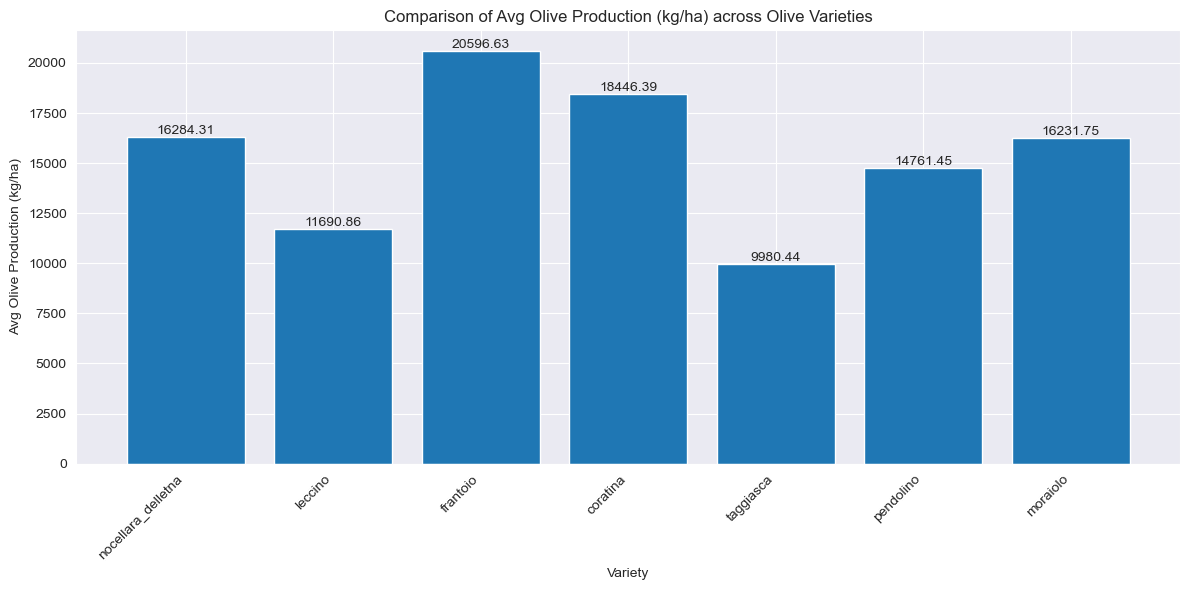

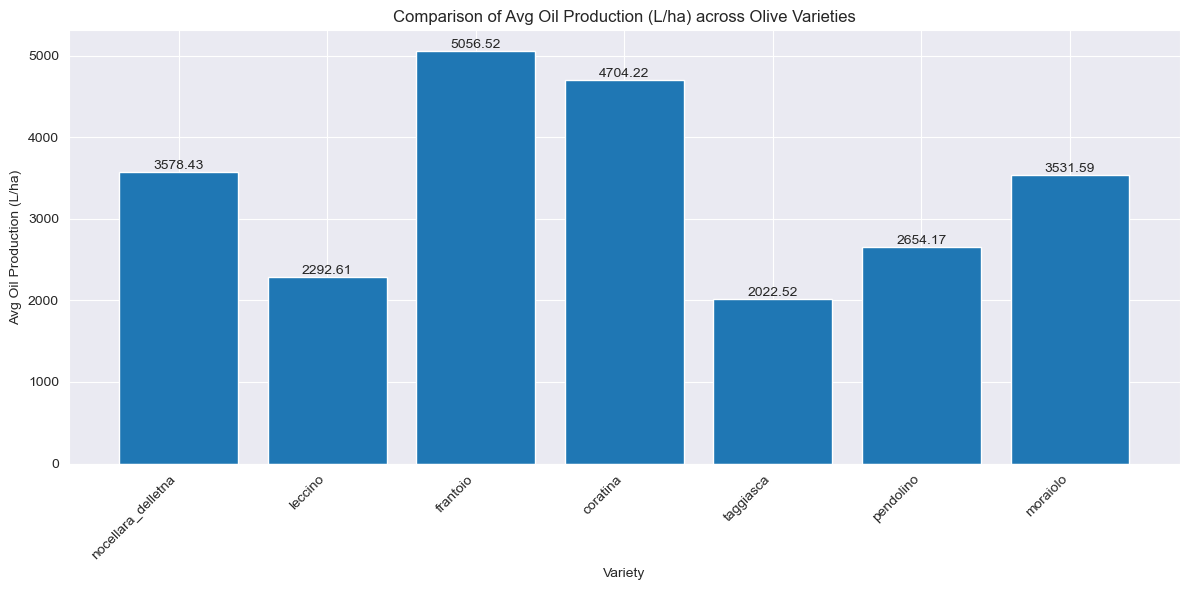

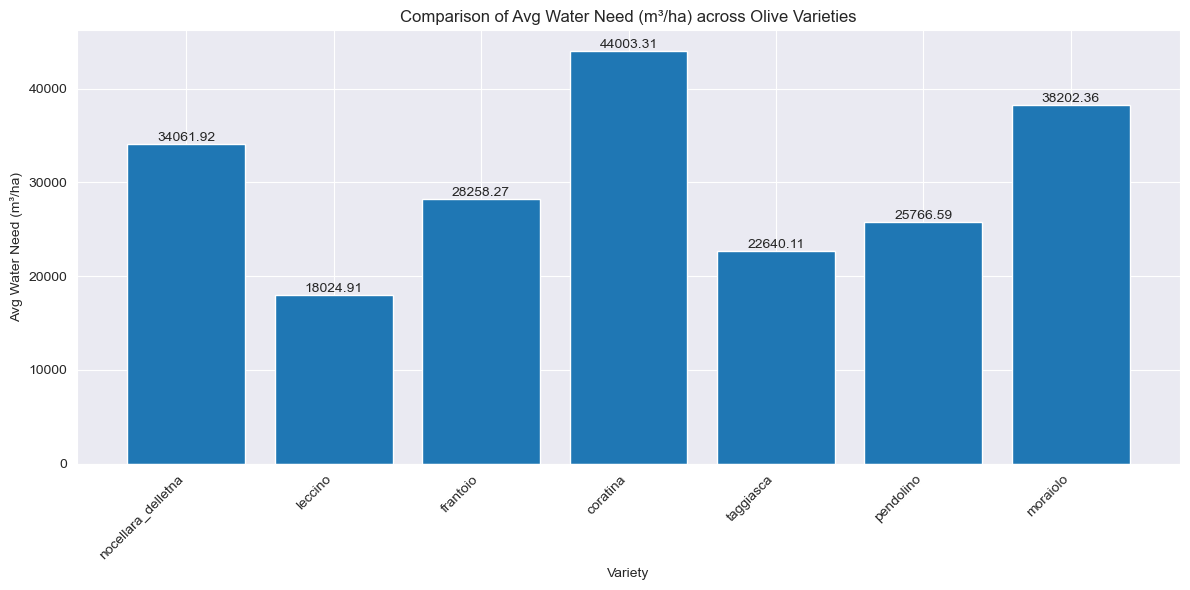

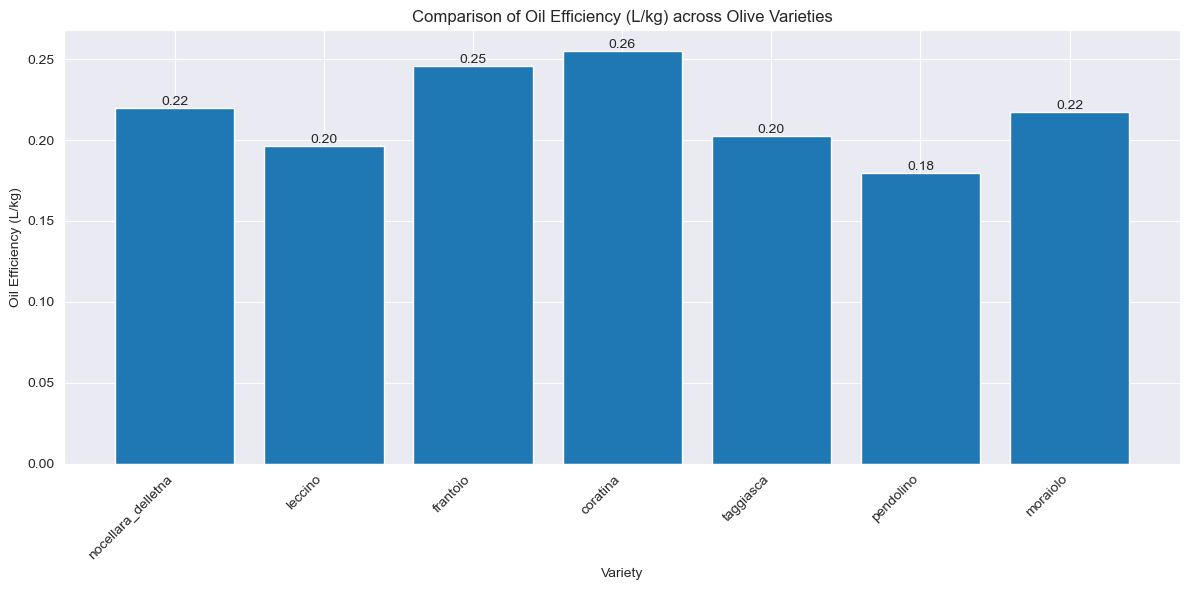

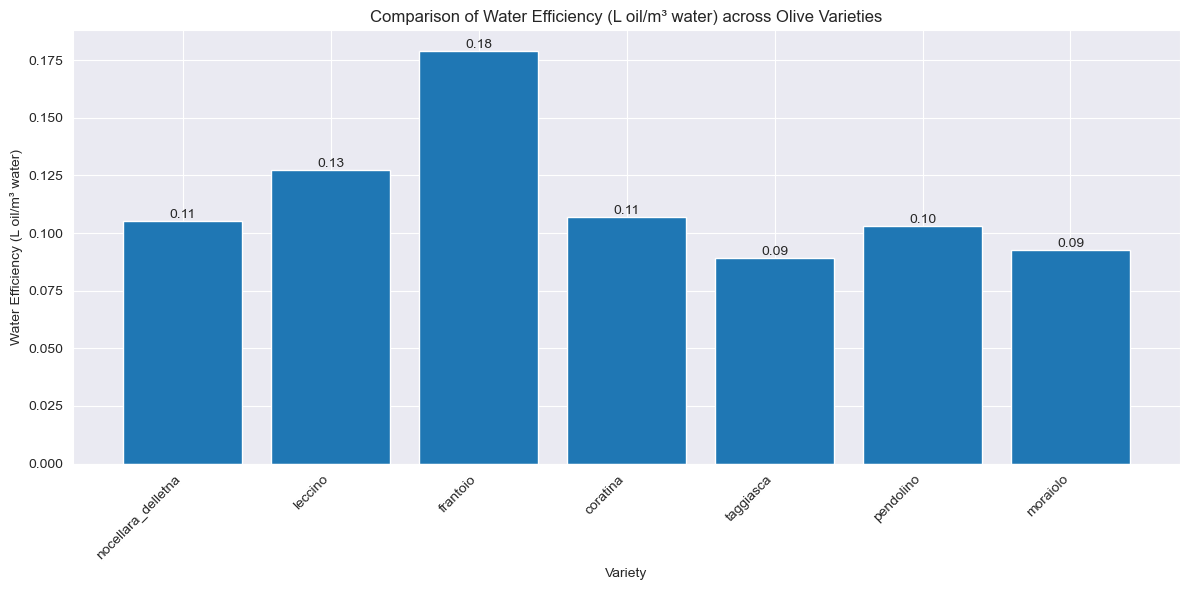

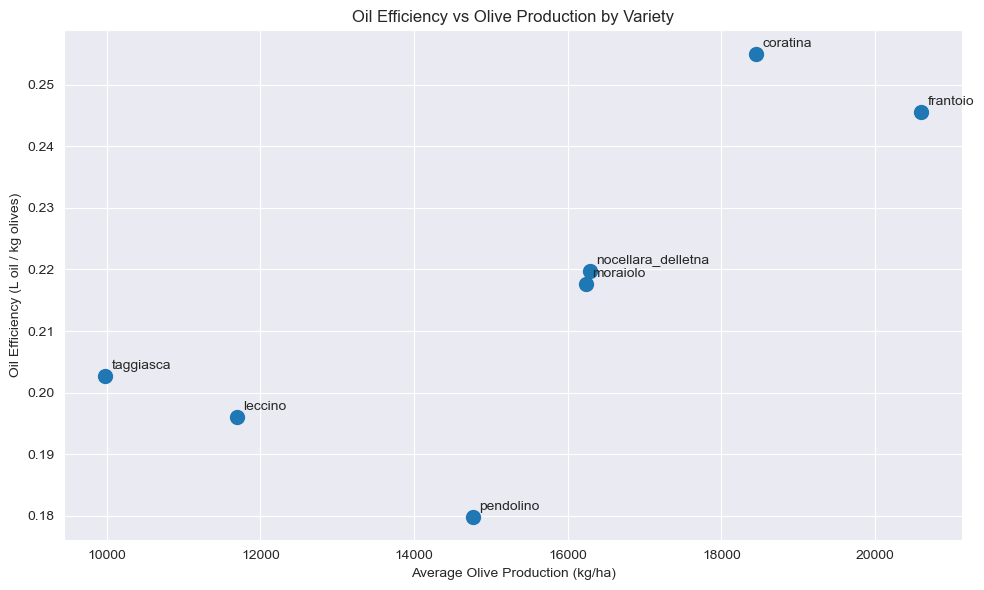

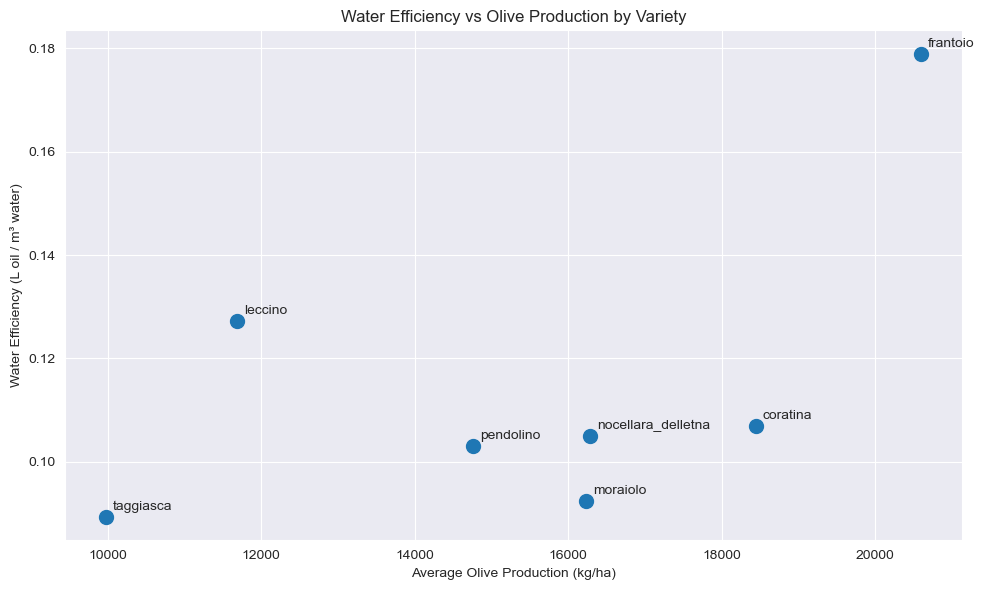

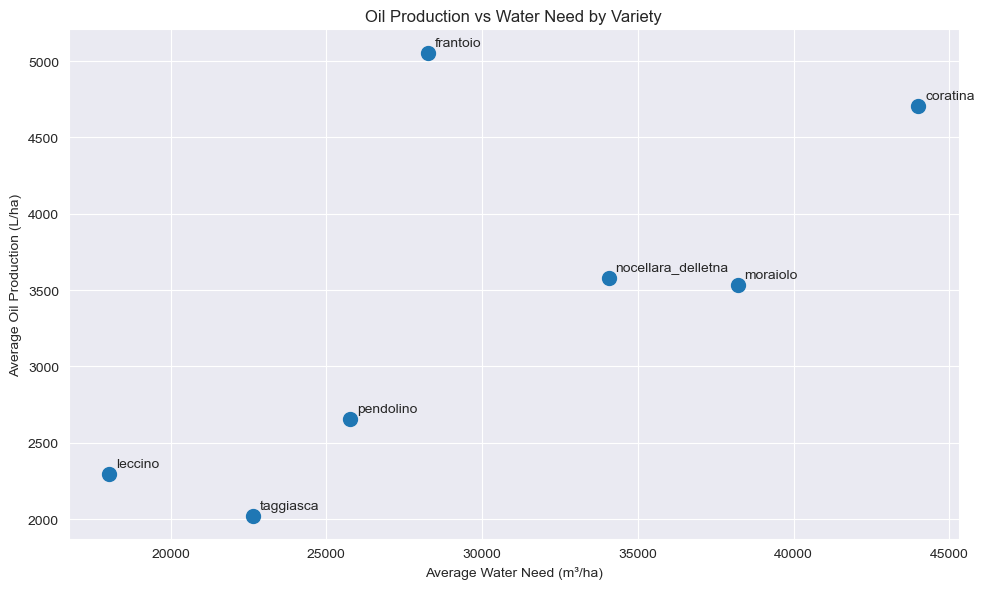

               Variety  Technique Technique String  \
0   nocellara_delletna          1        intensiva   
1   nocellara_delletna          2   superintensiva   
2   nocellara_delletna          3     tradizionale   
3              leccino          2   superintensiva   
4              leccino          1        intensiva   
5              leccino          3     tradizionale   
6             frantoio          2   superintensiva   
7             frantoio          1        intensiva   
8             frantoio          3     tradizionale   
9             coratina          3     tradizionale   
10            coratina          2   superintensiva   
11            coratina          1        intensiva   
12           taggiasca          1        intensiva   
13           taggiasca          2   superintensiva   
14           taggiasca          3     tradizionale   
15           pendolino          2   superintensiva   
16           pendolino          1        intensiva   
17           pendolino      

In [25]:
simulated_data = pd.read_parquet("./data/simulated_data.parquet")


def clean_column_names(df):
    # Funzione per pulire i nomi delle colonne
    new_columns = []
    for col in df.columns:
        # Usa regex per separare le varietà
        varieties = re.findall(r'([a-z]+)_([a-z_]+)', col)
        if varieties:
            new_columns.append(f"{varieties[0][0]}_{varieties[0][1]}")
        else:
            new_columns.append(col)
    return new_columns


def prepare_comparison_data(simulated_data, olive_varieties):
    # Pulisci i nomi delle colonne
    df = simulated_data.copy()

    df.columns = clean_column_names(df)
    df = encode_techniques(df)

    all_varieties = olive_varieties['Varietà di Olive'].unique()
    varieties = [clean_column_name(variety) for variety in all_varieties]
    comparison_data = []

    for variety in varieties:
        olive_prod_col = next((col for col in df.columns if col.startswith(f'{variety}_') and col.endswith('_olive_prod')), None)
        oil_prod_col = next((col for col in df.columns if col.startswith(f'{variety}_') and col.endswith('_avg_oil_prod')), None)
        tech_col = next((col for col in df.columns if col.startswith(f'{variety}_') and col.endswith('_tech')), None)
        water_need_col = next((col for col in df.columns if col.startswith(f'{variety}_') and col.endswith('_water_need')), None)

        if olive_prod_col and oil_prod_col and tech_col and water_need_col:
            variety_data = df[[olive_prod_col, oil_prod_col, tech_col, water_need_col]]
            variety_data = variety_data[variety_data[tech_col] != 0]  # Esclude le righe dove la tecnica è 0

            if not variety_data.empty:
                avg_olive_prod = pd.to_numeric(variety_data[olive_prod_col], errors='coerce').mean()
                avg_oil_prod = pd.to_numeric(variety_data[oil_prod_col], errors='coerce').mean()
                avg_water_need = pd.to_numeric(variety_data[water_need_col], errors='coerce').mean()
                efficiency = avg_oil_prod / avg_olive_prod if avg_olive_prod > 0 else 0
                water_efficiency = avg_oil_prod / avg_water_need if avg_water_need > 0 else 0

                comparison_data.append({
                    'Variety': variety,
                    'Avg Olive Production (kg/ha)': avg_olive_prod,
                    'Avg Oil Production (L/ha)': avg_oil_prod,
                    'Avg Water Need (m³/ha)': avg_water_need,
                    'Oil Efficiency (L/kg)': efficiency,
                    'Water Efficiency (L oil/m³ water)': water_efficiency
                })

    return pd.DataFrame(comparison_data)


def plot_variety_comparison(comparison_data, metric):
    plt.figure(figsize=(12, 6))
    bars = plt.bar(comparison_data['Variety'], comparison_data[metric])
    plt.title(f'Comparison of {metric} across Olive Varieties')
    plt.xlabel('Variety')
    plt.ylabel(metric)
    plt.xticks(rotation=45, ha='right')

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2., height,
                 f'{height:.2f}',
                 ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


def plot_efficiency_vs_production(comparison_data):
    plt.figure(figsize=(10, 6))

    plt.scatter(comparison_data['Avg Olive Production (kg/ha)'],
                comparison_data['Oil Efficiency (L/kg)'],
                s=100)

    for i, row in comparison_data.iterrows():
        plt.annotate(row['Variety'],
                     (row['Avg Olive Production (kg/ha)'], row['Oil Efficiency (L/kg)']),
                     xytext=(5, 5), textcoords='offset points')

    plt.title('Oil Efficiency vs Olive Production by Variety')
    plt.xlabel('Average Olive Production (kg/ha)')
    plt.ylabel('Oil Efficiency (L oil / kg olives)')
    plt.tight_layout()
    plt.show()


def plot_water_efficiency_vs_production(comparison_data):
    plt.figure(figsize=(10, 6))

    plt.scatter(comparison_data['Avg Olive Production (kg/ha)'],
                comparison_data['Water Efficiency (L oil/m³ water)'],
                s=100)

    for i, row in comparison_data.iterrows():
        plt.annotate(row['Variety'],
                     (row['Avg Olive Production (kg/ha)'], row['Water Efficiency (L oil/m³ water)']),
                     xytext=(5, 5), textcoords='offset points')

    plt.title('Water Efficiency vs Olive Production by Variety')
    plt.xlabel('Average Olive Production (kg/ha)')
    plt.ylabel('Water Efficiency (L oil / m³ water)')
    plt.tight_layout()
    plt.show()


def plot_water_need_vs_oil_production(comparison_data):
    plt.figure(figsize=(10, 6))

    plt.scatter(comparison_data['Avg Water Need (m³/ha)'],
                comparison_data['Avg Oil Production (L/ha)'],
                s=100)

    for i, row in comparison_data.iterrows():
        plt.annotate(row['Variety'],
                     (row['Avg Water Need (m³/ha)'], row['Avg Oil Production (L/ha)']),
                     xytext=(5, 5), textcoords='offset points')

    plt.title('Oil Production vs Water Need by Variety')
    plt.xlabel('Average Water Need (m³/ha)')
    plt.ylabel('Average Oil Production (L/ha)')
    plt.tight_layout()
    plt.show()


def analyze_by_technique(simulated_data, olive_varieties):
    # Pulisci i nomi delle colonne
    df = simulated_data.copy()

    df.columns = clean_column_names(df)
    df = encode_techniques(df)
    all_varieties = olive_varieties['Varietà di Olive'].unique()
    varieties = [clean_column_name(variety) for variety in all_varieties]

    technique_data = []

    for variety in varieties:
        olive_prod_col = next((col for col in df.columns if col.startswith(f'{variety}_') and col.endswith('_olive_prod')), None)
        oil_prod_col = next((col for col in df.columns if col.startswith(f'{variety}_') and col.endswith('_avg_oil_prod')), None)
        tech_col = next((col for col in df.columns if col.startswith(f'{variety}_') and col.endswith('_tech')), None)
        water_need_col = next((col for col in df.columns if col.startswith(f'{variety}_') and col.endswith('_water_need')), None)

        if olive_prod_col and oil_prod_col and tech_col and water_need_col:
            variety_data = df[[olive_prod_col, oil_prod_col, tech_col, water_need_col]]
            variety_data = variety_data[variety_data[tech_col] != 0]

            if not variety_data.empty:
                for tech in variety_data[tech_col].unique():
                    tech_data = variety_data[variety_data[tech_col] == tech]

                    avg_olive_prod = pd.to_numeric(tech_data[olive_prod_col], errors='coerce').mean()
                    avg_oil_prod = pd.to_numeric(tech_data[oil_prod_col], errors='coerce').mean()
                    avg_water_need = pd.to_numeric(tech_data[water_need_col], errors='coerce').mean()

                    efficiency = avg_oil_prod / avg_olive_prod if avg_olive_prod > 0 else 0
                    water_efficiency = avg_oil_prod / avg_water_need if avg_water_need > 0 else 0

                    technique_data.append({
                        'Variety': variety,
                        'Technique': tech,
                        'Technique String': decode_single_technique(tech),
                        'Avg Olive Production (kg/ha)': avg_olive_prod,
                        'Avg Oil Production (L/ha)': avg_oil_prod,
                        'Avg Water Need (m³/ha)': avg_water_need,
                        'Oil Efficiency (L/kg)': efficiency,
                        'Water Efficiency (L oil/m³ water)': water_efficiency
                    })

    return pd.DataFrame(technique_data)


# Esecuzione dell'analisi
comparison_data = prepare_comparison_data(simulated_data, olive_varieties)

# Genera i grafici
plot_variety_comparison(comparison_data, 'Avg Olive Production (kg/ha)')
plot_variety_comparison(comparison_data, 'Avg Oil Production (L/ha)')
plot_variety_comparison(comparison_data, 'Avg Water Need (m³/ha)')
plot_variety_comparison(comparison_data, 'Oil Efficiency (L/kg)')
plot_variety_comparison(comparison_data, 'Water Efficiency (L oil/m³ water)')
plot_efficiency_vs_production(comparison_data)
plot_water_efficiency_vs_production(comparison_data)
plot_water_need_vs_oil_production(comparison_data)

# Analisi per tecnica
technique_data = analyze_by_technique(simulated_data, olive_varieties)

print(technique_data)

# Stampa un sommario statistico
print("Comparison by Variety:")
print(comparison_data.set_index('Variety'))
print("\nBest Varieties by Water Efficiency:")
print(comparison_data.sort_values('Water Efficiency (L oil/m³ water)', ascending=False).head())

## 4. Analisi della Relazione tra Meteo e Produzione

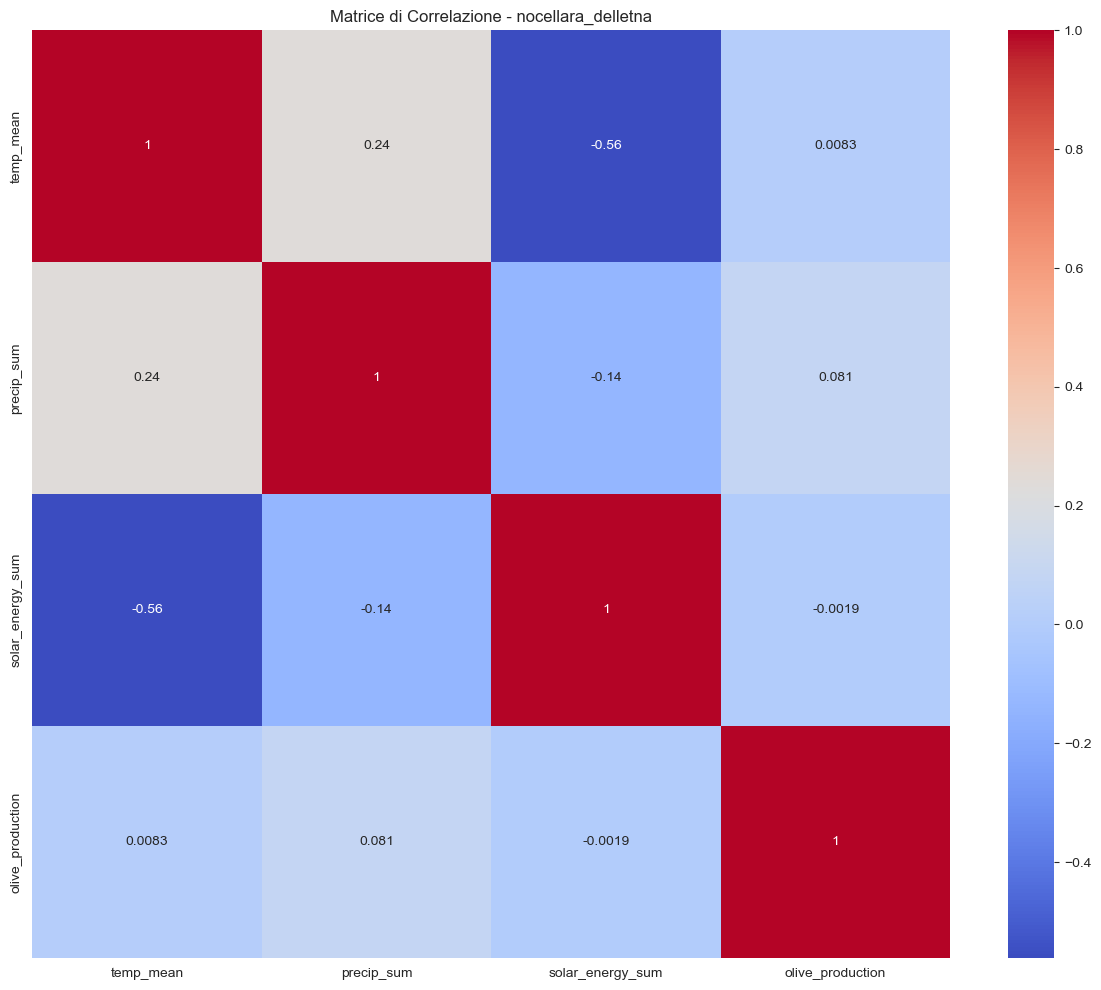

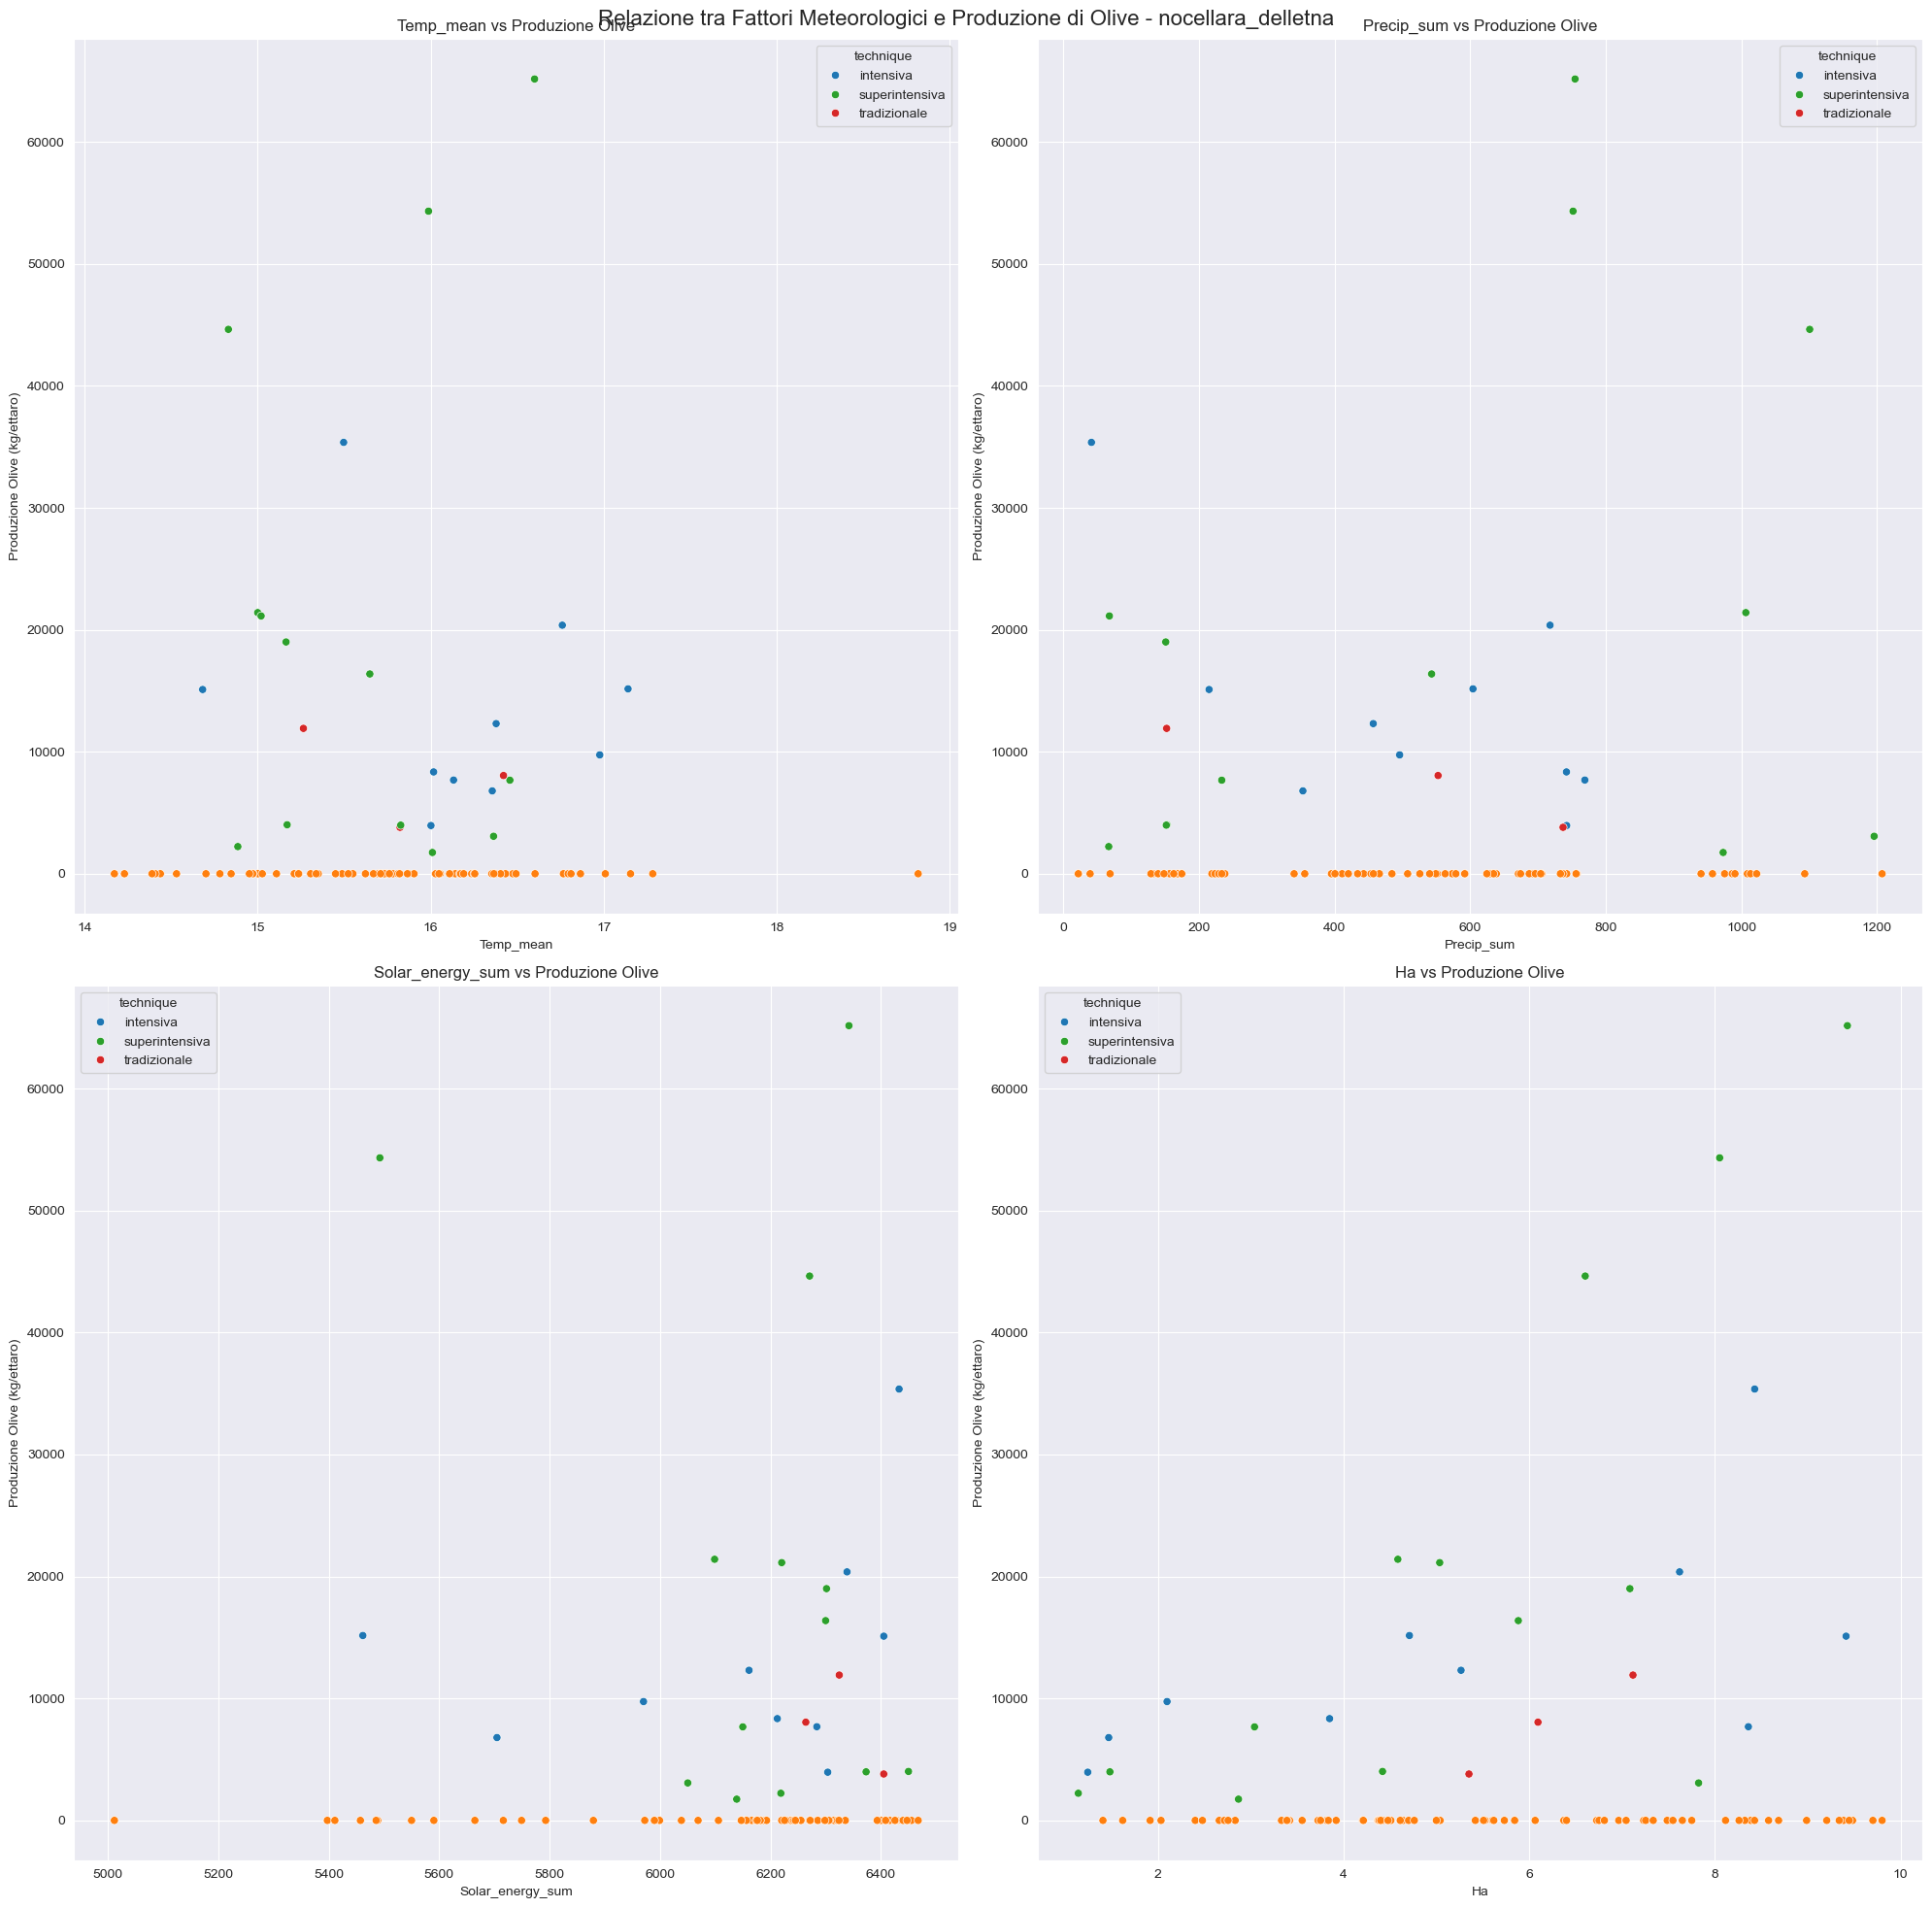

In [26]:
def get_full_data(simulated_data, olive_varieties):
    # Assumiamo che simulated_data contenga già tutti i dati necessari
    # Includiamo solo le colonne rilevanti
    relevant_columns = ['year', 'temp_mean', 'precip_sum', 'solar_energy_sum', 'ha', 'zone', 'olive_prod']

    # Aggiungiamo le colonne specifiche per varietà
    all_varieties = olive_varieties['Varietà di Olive'].unique()
    varieties = [clean_column_name(variety) for variety in all_varieties]
    for variety in varieties:
        relevant_columns.extend([f'{variety}_olive_prod', f'{variety}_tech'])

    return simulated_data[relevant_columns].copy()


def analyze_correlations(full_data, variety):
    # Filtra i dati per la varietà specifica
    variety_data = full_data[[col for col in full_data.columns if not col.startswith('_') or col.startswith(f'{variety}_')]]

    # Rinomina le colonne per chiarezza
    variety_data = variety_data.rename(columns={
        f'{variety}_olive_prod': 'olive_production',
        f'{variety}_tech': 'technique'
    })

    # Matrice di correlazione
    plt.figure(figsize=(12, 10))
    corr_matrix = variety_data[['temp_mean', 'precip_sum', 'solar_energy_sum', 'olive_production']].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title(f'Matrice di Correlazione - {variety}')
    plt.tight_layout()
    plt.show()

    # Scatter plots
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    fig.suptitle(f'Relazione tra Fattori Meteorologici e Produzione di Olive - {variety}', fontsize=16)

    for ax, var in zip(axes.flat, ['temp_mean', 'precip_sum', 'solar_energy_sum', 'ha']):
        sns.scatterplot(data=variety_data, x=var, y='olive_production', hue='technique', ax=ax)
        ax.set_title(f'{var.capitalize()} vs Produzione Olive')
        ax.set_xlabel(var.capitalize())
        ax.set_ylabel('Produzione Olive (kg/ettaro)')

    plt.tight_layout()
    plt.show()


# Uso delle funzioni
full_data = get_full_data(simulated_data, olive_varieties)

# Assumiamo che 'selected_variety' sia definito altrove nel codice
# Per esempio:
selected_variety = 'nocellara_delletna'

analyze_correlations(full_data, selected_variety)

## 5. Preparazione del Modello di Machine Learning

In [53]:
def prepare_data(df, olive_varieties_df):
    # Crea una copia del DataFrame per evitare modifiche all'originale
    df = df.copy()

    # Ordina per zona e anno
    df = df.sort_values(['zone', 'year'])

    # Definisci le feature
    temporal_features = ['temp_mean', 'precip_sum', 'solar_energy_sum']
    static_features = ['ha']  # Feature statiche base
    target_features = ['olive_prod', 'min_oil_prod', 'max_oil_prod', 'avg_oil_prod', 'total_water_need']

    # Ottieni le varietà pulite
    varieties = [clean_column_name(variety) for variety in olive_varieties_df['Varietà di Olive']]

    # Crea la struttura delle feature per ogni varietà
    variety_features = [
        'tech', 'pct', 'prod_t_ha', 'oil_prod_t_ha', 'oil_prod_l_ha',
        'min_yield_pct', 'max_yield_pct', 'min_oil_prod_l_ha', 'max_oil_prod_l_ha',
        'avg_oil_prod_l_ha', 'l_per_t', 'min_l_per_t', 'max_l_per_t', 'avg_l_per_t'
    ]

    # Prepara dizionari per le nuove colonne
    new_columns = {}

    # Prepara le feature per ogni varietà
    for variety in varieties:
        # Feature esistenti
        for feature in variety_features:
            col_name = f"{variety}_{feature}"
            if col_name in df.columns:
                if feature != 'tech':  # Non includere la colonna tech direttamente
                    static_features.append(col_name)

        # Feature binarie per le tecniche di coltivazione
        for technique in ['tradizionale', 'intensiva', 'superintensiva']:
            col_name = f"{variety}_{technique}"
            new_columns[col_name] = df[f"{variety}_tech"].notna() & (
                    df[f"{variety}_tech"].str.lower() == technique
            ).fillna(False)
            static_features.append(col_name)

    # Aggiungi tutte le nuove colonne in una volta sola
    new_df = pd.concat([df] + [pd.Series(v, name=k) for k, v in new_columns.items()], axis=1)

    #print("Temporal features:", temporal_features)
    #print("Static features:", static_features)

    # Crea scalers separati per ogni tipo di dato
    scaler_temporal = StandardScaler()
    scaler_static = StandardScaler()
    scaler_y = StandardScaler()

    # Prepara array per i dati
    zones = new_df['zone'].unique()
    years = new_df['year'].unique()
    years.sort()

    # Inizializza arrays con le dimensioni corrette
    X_temporal = np.zeros((len(zones), len(years), len(temporal_features)))
    X_static = np.zeros((len(zones), len(static_features)))
    y = np.zeros((len(zones), len(target_features)))

    # Popola gli arrays
    for i, zone in enumerate(zones):
        zone_data = new_df[new_df['zone'] == zone]
        # Dati statici
        X_static[i] = zone_data[static_features].iloc[0].values

        # Per i target, prendiamo solo l'ultimo anno disponibile per il training
        # Questo simula una predizione per il prossimo anno
        last_year_data = zone_data.iloc[-1]
        y[i] = last_year_data[target_features].values

    #print("\nShape prima dello split:")
    #print("X_temporal shape:", X_temporal.shape)
    #print("X_static shape:", X_static.shape)
    #print("y shape:", y.shape)

    # Dividi i dati in train, validation e test
    # Modifica: ora dividiamo per zone invece che per anni
    n_zones = len(zones)
    train_idx = int(n_zones * 0.7)  # 70% per training
    val_idx = int(n_zones * 0.85)  # 15% per validation

    # Split dei dati
    X_temporal_train = X_temporal[:train_idx]
    X_temporal_val = X_temporal[train_idx:val_idx]
    X_temporal_test = X_temporal[val_idx:]

    X_static_train = X_static[:train_idx]
    X_static_val = X_static[train_idx:val_idx]
    X_static_test = X_static[val_idx:]

    y_train = y[:train_idx]
    y_val = y[train_idx:val_idx]
    y_test = y[val_idx:]

    # Standardizzazione
    X_temporal_train = scaler_temporal.fit_transform(X_temporal_train.reshape(-1, len(temporal_features))).reshape(X_temporal_train.shape)
    X_temporal_val = scaler_temporal.transform(X_temporal_val.reshape(-1, len(temporal_features))).reshape(X_temporal_val.shape)
    X_temporal_test = scaler_temporal.transform(X_temporal_test.reshape(-1, len(temporal_features))).reshape(X_temporal_test.shape)

    X_static_train = scaler_static.fit_transform(X_static_train)
    X_static_val = scaler_static.transform(X_static_val)
    X_static_test = scaler_static.transform(X_static_test)

    y_train = scaler_y.fit_transform(y_train)
    y_val = scaler_y.transform(y_val)
    y_test = scaler_y.transform(y_test)

    # Prepara i dizionari di input
    train_data = {'temporal': X_temporal_train, 'static': X_static_train}
    val_data = {'temporal': X_temporal_val, 'static': X_static_val}
    test_data = {'temporal': X_temporal_test, 'static': X_static_test}

    #print("\nShape dopo lo split:")
    #print("Train temporal shape:", train_data['temporal'].shape)
    #print("Train static shape:", train_data['static'].shape)
    #print("Train target shape:", y_train.shape)

    return (train_data, y_train), (val_data, y_val), (test_data, y_test), (scaler_temporal, scaler_static, scaler_y)

## Divisione train/validation/test:


In [54]:
simulated_data = pd.read_parquet("./data/simulated_data.parquet")
olive_varieties = pd.read_parquet("./data/olive_varieties.parquet")

(train_data, train_targets), (val_data, val_targets), (test_data, test_targets), scalers = prepare_data(simulated_data, olive_varieties)

scaler_temporal, scaler_static, scaler_y = scalers

print("Temporal data shape:", train_data['temporal'].shape)
print("Static data shape:", train_data['static'].shape)
print("Target shape:", train_targets.shape)

Temporal data shape: (70, 39, 3)
Static data shape: (70, 337)
Target shape: (70, 5)


## OliveOilTransformer

In [29]:
import tensorflow as tf


class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]


class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation="relu"),
            tf.keras.layers.Dense(embed_dim),
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


class OliveOilTransformer(tf.keras.Model):
    def __init__(self, input_shape, num_outputs, d_model=64, num_heads=8, ff_dim=64, num_transformer_blocks=4, mlp_units=[128, 64], dropout=0.1, mlp_dropout=0.1):
        super(OliveOilTransformer, self).__init__()

        # Input shape dovrebbe essere (seq_length, num_features)
        self.input_layer = tf.keras.layers.Input(shape=input_shape)

        # Feature projection
        self.feature_projection = tf.keras.layers.Dense(d_model)

        # Positional encoding
        self.pos_encoding = PositionalEncoding(position=input_shape[0], d_model=d_model)

        # Transformer blocks
        self.transformer_blocks = []
        for _ in range(num_transformer_blocks):
            self.transformer_blocks.append(TransformerBlock(d_model, num_heads, ff_dim, dropout))

        # Output layers
        self.global_average_pooling = tf.keras.layers.GlobalAveragePooling1D()
        self.dropout = tf.keras.layers.Dropout(mlp_dropout)

        # MLP head
        self.mlp_layers = []
        for dim in mlp_units:
            self.mlp_layers.append(tf.keras.layers.Dense(dim, activation="relu"))
            self.mlp_layers.append(tf.keras.layers.Dropout(mlp_dropout))

        self.final_layer = tf.keras.layers.Dense(num_outputs)

        # Build the model
        inputs = tf.keras.layers.Input(shape=input_shape)
        outputs = self.call(inputs)
        self._model = tf.keras.Model(inputs=inputs, outputs=outputs)

    def call(self, inputs, training=None):
        x = inputs

        # Project features to d_model dimension
        x = self.feature_projection(x)

        # Add positional encoding
        x = self.pos_encoding(x)

        # Apply transformer blocks
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x, training=training)

        # Global pooling
        x = self.global_average_pooling(x)

        # Apply MLP layers
        for layer in self.mlp_layers:
            x = layer(x, training=training)

        # Final output
        return self.final_layer(x)

    def model(self):
        return self._model


# Costruisci il modello
model = OliveOilTransformer(
    input_shape=(train_data.shape[1], train_data.shape[2]),  # (seq_length, num_features)
    num_outputs=train_targets.shape[-1]  # numero di target
)

# Compila il modello
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# Mostra il summary
model.model().summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 34, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_219 (Dense)               │ (None, 34, 64)         │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_encoding_18          │ (None, 34, 64)         │             0 │
│ (PositionalEncoding)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_72            │ (None, 34, 64)         │       141,248 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_73            │ (None, 34, 64)         │       141,248 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_74            │ (None, 34, 64)         │       141,248 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_75            │ (None, 34, 64)         │       141,248 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_18     │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_228 (Dense)               │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_201 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_229 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_202 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_230 (Dense)               │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 582,213 (2.22 MB)

 Trainable params: 582,213 (2.22 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training

In [30]:
# Addestramento
history = model.fit(
    train_data,
    train_targets,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6
        )
    ]
)

Epoch 1/100


/usr/local/anaconda3/envs/ml_env/lib/python3.10/site-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'olive_oil_transformer_18', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
2024-10-24 11:33:43.277232: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [32,34,5] vs. [32,5]
	 [[{{function_node __inference_one_step_on_data_37911}}{{node gradient_tape/compile_loss/mse/sub/BroadcastGradientArgs}}]]


InvalidArgumentError: Graph execution error:

Detected at node gradient_tape/compile_loss/mse/sub/BroadcastGradientArgs defined at (most recent call last):
  File "/usr/local/anaconda3/envs/ml_env/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/local/anaconda3/envs/ml_env/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/anaconda3/envs/ml_env/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/usr/local/anaconda3/envs/ml_env/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/usr/local/anaconda3/envs/ml_env/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 701, in start

  File "/usr/local/anaconda3/envs/ml_env/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/local/anaconda3/envs/ml_env/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/local/anaconda3/envs/ml_env/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/local/anaconda3/envs/ml_env/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/anaconda3/envs/ml_env/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue

  File "/usr/local/anaconda3/envs/ml_env/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 523, in process_one

  File "/usr/local/anaconda3/envs/ml_env/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell

  File "/usr/local/anaconda3/envs/ml_env/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/usr/local/anaconda3/envs/ml_env/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/usr/local/anaconda3/envs/ml_env/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/usr/local/anaconda3/envs/ml_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/usr/local/anaconda3/envs/ml_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/usr/local/anaconda3/envs/ml_env/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/usr/local/anaconda3/envs/ml_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/usr/local/anaconda3/envs/ml_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/usr/local/anaconda3/envs/ml_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/var/folders/j4/dltmqwjj1438ftthspk8_knm0000gn/T/ipykernel_2258/3746327179.py", line 2, in <module>

  File "/usr/local/anaconda3/envs/ml_env/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/anaconda3/envs/ml_env/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit

  File "/usr/local/anaconda3/envs/ml_env/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/usr/local/anaconda3/envs/ml_env/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/usr/local/anaconda3/envs/ml_env/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 70, in train_step

Incompatible shapes: [32,34,5] vs. [32,5]
	 [[{{node gradient_tape/compile_loss/mse/sub/BroadcastGradientArgs}}]] [Op:__inference_one_step_on_iterator_38382]

In [ ]:
next_year_production = model.predict(next_year_weather.mean().to_frame().T)[0]
print(f'Previsione produzione di olive per il prossimo anno: {next_year_production:.2f} kg/ettaro')

## 8. Conclusioni e Prossimi Passi

In questo notebook, abbiamo:
1. Caricato e analizzato i dati meteorologici
2. Simulato la produzione annuale di olive basata sui dati meteo
3. Esplorato le relazioni tra variabili meteorologiche e produzione di olive
4. Creato e valutato un modello di machine learning per prevedere la produzione
5. Utilizzato ARIMA per fare previsioni meteo
6. Previsto la produzione di olive per il prossimo anno

Prossimi passi:
- Raccogliere dati reali sulla produzione di olive per sostituire i dati simulati
- Esplorare modelli più avanzati, come le reti neurali o i modelli di ensemble
- Incorporare altri fattori che potrebbero influenzare la produzione, come le pratiche agricole o l'età degli alberi
- Sviluppare una dashboard interattiva basata su questo modello